# Check Python version and upgrading

In [101]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import sys
import os

In [4]:
# !conda update -n base -c defaults conda
# !conda install -y pytorch torchvision -c pytorch

In [5]:
!pip uninstall -y numpy 
!pip install numpy

Found existing installation: numpy 1.23.1
Uninstalling numpy-1.23.1:
  Successfully uninstalled numpy-1.23.1
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.23.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.10.0 which is incompatible.
seqeval 1.2.0 requires numpy==1.19.2, but you have numpy 1.23.1 which is incompatible.
en-core-web-lg 3.4.0 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.2.4 which is incompatible.
deeppavlov 0.17.4 requires filelock==3.0.12, but you have filelock 3.6.0 which is incompatible.
deeppavlov 0.17.4 requires numpy==1.18.0, but you have numpy 1.23.1 which is incompatible.
deeppavlov 0.17.4 requires overrides==2.7.0, but you have overrides 3.1.0 which 

# Installations of 3 key libraries: KILT, GENRE and fairseq

In [6]:
#KILT
%rm -rf KILT
!git clone https://github.com/facebookresearch/KILT.git
%cd KILT
!pip install -r requirements.txt
!python setup.py install
sys.path.append(os.getcwd())
%cd ..

#GENRE
%rm -rf GENRE
!git clone https://github.com/facebookresearch/GENRE.git
%cd GENRE
!pip install ./
!python ./setup.py build develop install
!pip install sentencepiece marisa_trie
sys.path.append(os.getcwd())
%cd ..

# fairseq
%rm -rf fairseq
!git clone --branch fixing_prefix_allowed_tokens_fn https://github.com/nicola-decao/fairseq
%cd fairseq
!sed -i -e '26,27d' fairseq/registry.py
!pip install --editable ./
!python setup.py build develop
!python setup.py install
sys.path.append(os.getcwd())
%cd ..

!pip install kilt

#####
%cd fairseq
!pip install --editable ./
%cd ..

Cloning into 'KILT'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 401 (delta 108), reused 92 (delta 92), pack-reused 250
Receiving objects: 100% (401/401), 829.97 KiB | 2.24 MiB/s, done.
Resolving deltas: 100% (224/224), done.
/home/petrakov/success/mGENRE_MEL/KILT
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Traceback (most recent call last):
  File "setup.py", line 8, in <module>
    import setuptools
ImportError: No module named setuptools
/home/petrakov/success/mGENRE_MEL
Cloning into 'GENRE'...
remote: Enumerating objects: 454, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 454 (delta 112), reused 104 (delta 80), pack-reused 284
Receiving objects: 100% (454/454), 10.99 MiB | 3.8

## import libraries

In [10]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable


In [37]:
import gdown
import json
import pickle
import torch
import gc
import re
from wikidata.client import Client
import pandas as pd
import numpy as np
from itertools import compress
from datetime import datetime
import matplotlib.pyplot as plt

## Upload data and model (comment cell below if already downloaded)

In [12]:
# # pretrained model
# ! rm -rf fairseq_multilingual_entity_disambiguation*
# ! wget https://dl.fbaipublicfiles.com/GENRE/fairseq_multilingual_entity_disambiguation.tar.gz
# ! tar -xvf fairseq_multilingual_entity_disambiguation.tar.gz

# # data
# ! wget https://dl.fbaipublicfiles.com/GENRE/lang_title2wikidataID-normalized_with_redirect.pkl
# ! wget http://dl.fbaipublicfiles.com/GENRE/titles_lang_all105_marisa_trie_with_redirect.pkl

## Install test data

In [18]:
id_ = "1QpLVXGahVjAoEq8TrE70aKtMLJCNeASh"
gdown.download('https://drive.google.com/uc?id=1QpLVXGahVjAoEq8TrE70aKtMLJCNeASh', output="mentions_test.json", quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1QpLVXGahVjAoEq8TrE70aKtMLJCNeASh
To: /home/petrakov/success/mGENRE_MEL/mentions_test.json
100%|██████████| 65.1M/65.1M [00:01<00:00, 64.9MB/s]


'mentions_test.json'

In [19]:
with open("mentions_test.json") as f:
    test_set = json.load(f)

In original version there were serious of troubles that's why correct version we add here from external google drive

In [55]:
%%writefile fairseq_model.py
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import copy
import logging
import os
from collections import defaultdict
from typing import Dict, List

import torch
from fairseq import search, utils
from fairseq.models.bart import BARTHubInterface, BARTModel
from omegaconf import open_dict

logger = logging.getLogger(__name__)


class GENREHubInterface(BARTHubInterface):
    def sample(
        self,
        sentences: List[str],
        beam: int = 5,
        verbose: bool = False,
        text_to_id=None,
        marginalize=False,
        marginalize_lenpen=0.5,
        max_len_a=1024,
        max_len_b=1024,
        **kwargs,
    ) -> List[str]:
        if isinstance(sentences, str):
            return self.sample([sentences], beam=beam, verbose=verbose, **kwargs)[0]
        tokenized_sentences = [self.encode(sentence) for sentence in sentences]

        batched_hypos = self.generate(
            tokenized_sentences,
            beam,
            verbose,
            max_len_a=max_len_a,
            max_len_b=max_len_b,
            **kwargs,
        )
        #print("batched_hypos", batched_hypos)
        
        outputs = [
            [
                {"text": self.decode(hypo["tokens"]), "score": hypo["score"]}
                for hypo in hypos
            ]
            for hypos in batched_hypos
        ]
        if text_to_id:
            outputs = [
                [{**hypo, "id": text_to_id(hypo["text"])} for hypo in hypos]
                for hypos in outputs
            ]

            if marginalize:
                for (i, hypos), hypos_tok in zip(enumerate(outputs), batched_hypos):
                    outputs_dict = defaultdict(list)
                    for hypo, hypo_tok in zip(hypos, hypos_tok):
                        outputs_dict[hypo["id"]].append(
                            {**hypo, "len": len(hypo_tok["tokens"])}
                        )

                    outputs[i] = sorted(
                        [
                            {
                                "id": _id,
                                "texts": [hypo["text"] for hypo in hypos],
                                "scores": torch.stack(
                                    [hypo["score"] for hypo in hypos]
                                ),
                                "score": torch.stack(
                                    [
                                        hypo["score"]
                                        * hypo["len"]
                                        / (hypo["len"] ** marginalize_lenpen)
                                        for hypo in hypos
                                    ]
                                ).logsumexp(-1),
                            }
                            for _id, hypos in outputs_dict.items()
                        ],
                        key=lambda x: x["score"],
                        reverse=True,
                    )

        return outputs

    def generate(self, *args, **kwargs) -> List[List[Dict[str, torch.Tensor]]]:
        return super(BARTHubInterface, self).generate(*args, **kwargs)

    def encode(self, sentence) -> torch.LongTensor:
        tokens = super(BARTHubInterface, self).encode(sentence)
        tokens[
            tokens >= len(self.task.target_dictionary)
        ] = self.task.target_dictionary.unk_index
        if tokens[0] != self.task.target_dictionary.bos_index:
            return torch.cat(
                (torch.tensor([self.task.target_dictionary.bos_index]), tokens)
            )
        else:
            return tokens

    
class GENRE(BARTModel):
    @classmethod
    def from_pretrained(
        cls,
        model_name_or_path,
        checkpoint_file="model.pt",
        data_name_or_path=".",
        bpe="gpt2",
        **kwargs,
    ):
        from fairseq import hub_utils

        x = hub_utils.from_pretrained(
            model_name_or_path,
            checkpoint_file,
            data_name_or_path,
            archive_map=cls.hub_models(),
            bpe=bpe,
            load_checkpoint_heads=True,
            **kwargs,
        )
        return GENREHubInterface(x["args"], x["task"], x["models"][0])


class mGENRE(BARTModel):
    @classmethod
    def from_pretrained(
        cls,
        model_name_or_path,
        sentencepiece_model="spm_256000.model",
        checkpoint_file="model.pt",
        data_name_or_path=".",
        bpe="sentencepiece",
        layernorm_embedding=True,
        **kwargs,
    ):
        from fairseq import hub_utils

        x = hub_utils.from_pretrained(
            model_name_or_path,
            checkpoint_file,
            data_name_or_path,
            archive_map=cls.hub_models(),
            bpe=bpe,
            load_checkpoint_heads=True,
            sentencepiece_model=os.path.join(model_name_or_path, sentencepiece_model),
            **kwargs,
        )
        return GENREHubInterface(x["args"], x["task"], x["models"][0])


Overwriting fairseq_model.py


In [56]:
%mv fairseq_model.py GENRE/genre

# Multilingual Autoregressive Entity Linking

![](s.png)

We are starting with importing our model mGENRE and it's important part, it was slightly changed in previous cells in order to reach stable work

In [57]:
from GENRE.genre.trie import Trie, MarisaTrie
from GENRE.genre.fairseq_model import mGENRE

Here we load data that connects titles with wikidata ids and trie that is an important part of the model

In [58]:
with open("lang_title2wikidataID-normalized_with_redirect.pkl", "rb") as f:
    lang_title2wikidataID = pickle.load(f)
  
# with open("titles_lang_all105_trie_with_redirect.pkl", "rb") as f:
#     trie = Trie.load_from_dict(pickle.load(f))

with open("titles_lang_all105_marisa_trie_with_redirect.pkl", "rb") as f:
    trie = pickle.load(f)

### Using GPU leads to faster inference, so if possible it is recommended

Here we chosen 4 because there were lot's of free memory on our own server, you can check the memory available for you using the command below

In [59]:
!nvidia-cdl

Driver version: 495.29.05
------------------- Device 0 -------------------
Name: NVIDIA GeForce RTX 3090
Memory usage: 23986MiB / 24268MiB
Temperature: 26C
Running processes not found

------------------- Device 1 -------------------
Name: NVIDIA GeForce RTX 3090
Memory usage: 20119MiB / 24268MiB
Temperature: 67C
Running processes not found

------------------- Device 2 -------------------
Name: NVIDIA GeForce RTX 3090
Memory usage: 23173MiB / 24268MiB
Temperature: 22C
Running processes not found

------------------- Device 3 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:  3502MiB / 11019MiB
Temperature: 23C
Running processes not found

------------------- Device 4 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage: 10251MiB / 11019MiB
Temperature: 25C
Running processes not found



In [60]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [61]:
# generate Wikipedia titles and language IDs
model_mGENRE = mGENRE.from_pretrained("fairseq_multilingual_entity_disambiguation").eval()
model_mGENRE.to(device)

/home/petrakov/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


GENREHubInterface(
  (models): ModuleList(
    (0): BARTModel(
      (encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(256001, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDro

Example of model result

In [62]:
sentences = ["[START] The founder of the theory of relativity [END] received the Nobel Prize."]
model_mGENRE.sample(
    sentences,
    beam = 5,
    prefix_allowed_tokens_fn=lambda batch_id, sent: [
        e for e in trie.get(sent.tolist())
        if e < len(model_mGENRE.task.target_dictionary)
    ],
    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
    marginalize=True,
    verbose = True
)

/home/petrakov/success/mGENRE_MEL/fairseq/fairseq/search.py:205: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/petrakov/success/mGENRE_MEL/fairseq/fairseq/sequence_generator.py:659: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // beam_size


[[{'id': 'Q937',
   'texts': ['Albert Einstein >> en'],
   'scores': tensor([-0.7137], device='cuda:3'),
   'score': tensor(-1.5959, device='cuda:3')},
  {'id': 'Q363005',
   'texts': ['John Singleton >> en'],
   'scores': tensor([-0.7909], device='cuda:3'),
   'score': tensor(-1.9374, device='cuda:3')},
  {'id': 'Q7374',
   'texts': ['Alfred Hitchcock >> en'],
   'scores': tensor([-0.8762], device='cuda:3'),
   'score': tensor(-2.3182, device='cuda:3')},
  {'id': 'Q715110',
   'texts': ['Robert Maynard >> en'],
   'scores': tensor([-0.8954], device='cuda:3'),
   'score': tensor(-2.3689, device='cuda:3')},
  {'id': 'Q9353',
   'texts': ['John Locke >> en'],
   'scores': tensor([-1.0060], device='cuda:3'),
   'score': tensor(-2.4641, device='cuda:3')}]]

Results above demonstrate that each *text* has it's own id and via marginalization procedure we have unique score for predicted entity

# Hypothesis of no [START] and [END]

Within this part we check that [START] and [END] tokens are really needed

In [20]:
sentences = ["Who invented radio?"]
model_mGENRE.sample(
    sentences,
    beam = 5,
    prefix_allowed_tokens_fn=lambda batch_id, sent: [
        e for e in trie.get(sent.tolist())
        if e < len(model_mGENRE.task.target_dictionary)
    ],
    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
    marginalize=True,
    verbose = True
)

[[{'id': 'Q1517374',
   'texts': ['History of radio >> en'],
   'scores': tensor([-0.4300], device='cuda:4'),
   'score': tensor(-1.0534, device='cuda:4')},
  {'id': 'Q1516738',
   'texts': ['Invention of radio >> en'],
   'scores': tensor([-0.6202], device='cuda:4'),
   'score': tensor(-1.6408, device='cuda:4')},
  {'id': 'Q16887156',
   'texts': ['List of inventions in the medieval Islamic world >> en',
    'List of inventions in the medieval Islamic world >> ar'],
   'scores': tensor([-0.5023, -1.5995], device='cuda:4'),
   'score': tensor(-1.7181, device='cuda:4')},
  {'id': 'Q4501817',
   'texts': ['Timeline of radio >> en'],
   'scores': tensor([-0.9116], device='cuda:4'),
   'score': tensor(-2.4119, device='cuda:4')}]]

In [21]:
sentences = ["When Second World war started?"]
model_mGENRE.sample(
    sentences,
    beam = 5,
    prefix_allowed_tokens_fn=lambda batch_id, sent: [
        e for e in trie.get(sent.tolist())
        if e < len(model_mGENRE.task.target_dictionary)
    ],
    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
    marginalize=True,
    verbose = True
)

[[{'id': 'Q362',
   'texts': ['World War II >> en', 'Second World War >> en'],
   'scores': tensor([-0.4641, -0.6737], device='cuda:4'),
   'score': tensor(-0.6678, device='cuda:4')},
  {'id': 'Q5370388',
   'texts': ['Military history of the United States during World War II >> en'],
   'scores': tensor([-0.2719], device='cuda:4'),
   'score': tensor(-0.9804, device='cuda:4')},
  {'id': 'Q192781',
   'texts': ['Military history >> en'],
   'scores': tensor([-0.8395], device='cuda:4'),
   'score': tensor(-1.8772, device='cuda:4')},
  {'id': 'Q131110',
   'texts': ['History of the United States >> en'],
   'scores': tensor([-0.7007], device='cuda:4'),
   'score': tensor(-1.9820, device='cuda:4')}]]

#### We can say that entities within simple questions like above correctly determine

# Quantitative assessment of the hypothesis

#### !!!before that you have to clone wikidata-simplequestions github repository (https://github.com/askplatypus/wikidata-simplequestions)

In [65]:
path_to_train_simple_questions = "/home/petrakov/wikidata-simplequestions/annotated_wd_data_train_answerable.txt"

In [66]:
data = pd.read_table(path_to_train_simple_questions, header=None).rename(columns = {0:"object", 1:"property", 2:"subject", 3:"question"})
data

,object,property,subject,question
0,Q12439,R19,Q6106580,who is a musician born in detroit
1,Q6817891,P364,Q1568,what is the language in which mera shikar was ...
2,Q1297,R276,Q2888523,Whats the name of a battle that happened in ch...
3,Q193592,R413,Q5822614,what player plays the position midfielder?
4,Q6849115,P413,Q336286,what is the position that mike twellman plays
...,...,...,...,...
19476,Q223960,P171,Q128001,what classification does mountain tapir come ...
19477,Q1535153,R136,Q7727315,What's a superhero movie that premiered on too...
19478,Q157443,R136,Q966690,What is the name of a comedy film that is also...
19479,Q16093542,P27,Q145,What is the nationality of anthony bailey


In [37]:
n = 100
start_time = datetime.now()


mGENRE_results = model_mGENRE.sample(
                                    list(data.loc[:n, "question"]),
                                    beam = 3,
                                    prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                        e for e in trie.get(sent.tolist())
                                        if e < len(model_mGENRE.task.target_dictionary)
                                    ],
                                    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                    marginalize=True,
                                    verbose = True
                                )


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


Duration: 0:00:42.891695


In [39]:
y_pred = [i[0]['id'] for i in mGENRE_results]
y_true = list(data.loc[:n, "object"])
result = [x in y_pred for x in y_true] 


### If we take only the most probable score

In [41]:
np.round(sum(result)/len(result), 4)

0.2475

### If we take an account all predicted ids

In [52]:
out = [[i['id'] for i in mGENRE_results[j]] for j in range(len(mGENRE_results))]

In [58]:
res = []
for index, out_list in enumerate(out):
    if y_true[index] in out_list:
        res.append(1)
    else:
        res.append(0)
        
    

In [60]:
np.round(sum(res)/len(res), 4)

0.3168

### If we take on account only those questions where we certain (top 1)

In [30]:
thresholds = [-3, -2, -1.5, -1, -0.75, -0.6, -0.4, -0.2, -0.1]

In [31]:
accuracy_100_top_1 = []
share_of_observations_100_top_1 = []

for threshold in thresholds:
    certain_out = [i[0]['id'] for i in mGENRE_results if i[0]['score'] > threshold]
    indexes = [1 if i[0]['score'] > threshold else 0 for i in mGENRE_results]
    y_true = list(compress(list(data.loc[:n, "object"]), indexes))
    result = [x in certain_out for x in y_true] 
    accuracy = np.round(sum(result)/len(result), 4)*100
    accuracy_100_top_1.append(accuracy)
    share = len(result)/n*100
    share_of_observations_100_top_1.append(share)
    
    print("threshold = ", threshold, "\t",
          "accuracy = ", accuracy, "%\t", 
          "number of observations = ", len(result), '\t',
          "share of observations = ", len(result)/n*100, "%")

threshold =  -3 	 accuracy =  2.8400000000000003 %	 number of observations =  387 	 share of observations =  96.75 %
threshold =  -2 	 accuracy =  3.0700000000000003 %	 number of observations =  326 	 share of observations =  81.5 %
threshold =  -1.5 	 accuracy =  3.35 %	 number of observations =  239 	 share of observations =  59.75 %
threshold =  -1 	 accuracy =  3.36 %	 number of observations =  149 	 share of observations =  37.25 %
threshold =  -0.75 	 accuracy =  1.87 %	 number of observations =  107 	 share of observations =  26.75 %
threshold =  -0.6 	 accuracy =  0.0 %	 number of observations =  78 	 share of observations =  19.5 %
threshold =  -0.4 	 accuracy =  0.0 %	 number of observations =  40 	 share of observations =  10.0 %
threshold =  -0.2 	 accuracy =  0.0 %	 number of observations =  12 	 share of observations =  3.0 %
threshold =  -0.1 	 accuracy =  0.0 %	 number of observations =  5 	 share of observations =  1.25 %


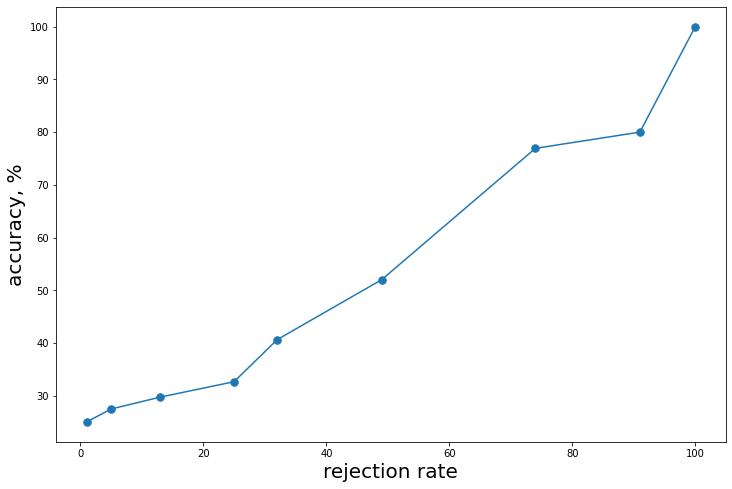

In [147]:
plt.figure(figsize = (12,8))
plt.xlabel("rejection rate, %", fontsize = 20)
plt.ylabel("accuracy, %", fontsize = 20)
plt.plot(share_of_observations_100_top_1[::-1], accuracy_100_top_1, marker = '.', markersize = 15);

## Add more observations

In [67]:
n = 400
start_time = datetime.now()


mGENRE_results = model_mGENRE.sample(
                                    list(data.sample(n = n, replace = False, random_state=1).loc[:, "question"]),
                                    beam = 3,
                                    prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                        e for e in trie.get(sent.tolist())
                                        if e < len(model_mGENRE.task.target_dictionary)
                                    ],
                                    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                    marginalize=True,
                                    verbose = True
                                )


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


/home/petrakov/success/mGENRE_MEL/fairseq/fairseq/search.py:205: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size


RuntimeError: CUDA out of memory. Tried to allocate 752.00 MiB (GPU 3; 10.76 GiB total capacity; 4.90 GiB already allocated; 615.56 MiB free; 5.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
thresholds = [-10, -3, -2, -1.5, -1, -0.75, -0.6, -0.4, -0.2, -0.1]
accuracy_400_top_1 = []
share_of_observations_400_top_1 = []

for threshold in thresholds:
    certain_out = [i[0]['id'] for i in mGENRE_results if i[0]['score'] > threshold]
    indexes = [1 if i[0]['score'] > threshold else 0 for i in mGENRE_results]
    y_true = list(compress(list(data.loc[list(data.sample(n = n, replace = False, random_state=1).index), "object"]), indexes))
    result = [x in certain_out for x in y_true] 
    accuracy = np.round(sum(result)/len(result), 2)*100
    accuracy_400_top_1.append(accuracy)
    share = np.round(len(result)/n*100, 2)
    share_of_observations_400_top_1.append(share)
    
    print("threshold = ", threshold, "\t",
          "accuracy = ", accuracy, "%\t", 
          "number of observations = ", len(result), '\t',
          "share of observations = ", share, "%")

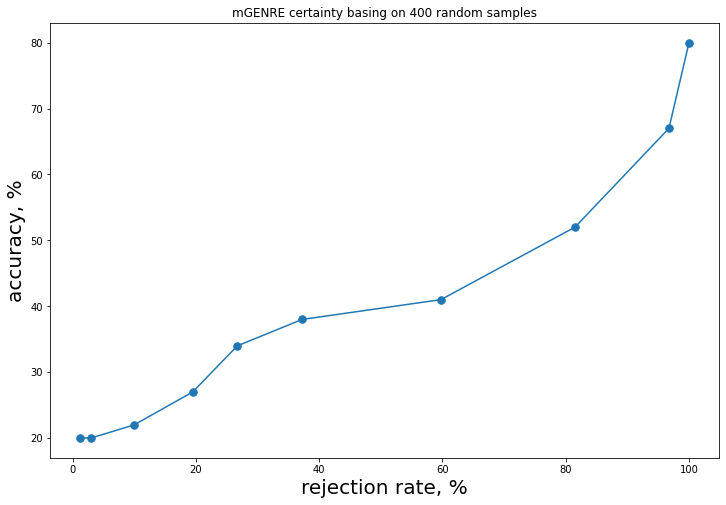

In [25]:
plt.figure(figsize = (12,8))
plt.xlabel("rejection rate, %", fontsize = 20)
plt.ylabel("accuracy, %", fontsize = 20)
plt.title("mGENRE certainty basing on 400 random samples")
plt.plot(share_of_observations_400_top_1[::-1], accuracy_400_top_1, marker = '.', markersize = 15);

### Batch approach to add observations

In [72]:
n = 400
start_time = datetime.now()

divider = 80

mGENRE_results = []
for i in range(divider):

    mGENRE_results_i = model_mGENRE.sample(
                                        list(data.sample(n = 5, replace = False, random_state=i).loc[:, "question"]),
                                        beam = 3,
                                        prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                            e for e in trie.get(sent.tolist())
                                            if e < len(model_mGENRE.task.target_dictionary)
                                        ],
                                        text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                        marginalize=True,
                                        verbose = True
                                    )
    mGENRE_results.append(mGENRE_results_i)
    print("part ", i, " done!")


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


part  0  done!
part  1  done!
part  2  done!
part  3  done!
part  4  done!
part  5  done!
part  6  done!
part  7  done!
part  8  done!
part  9  done!
part  10  done!
part  11  done!
part  12  done!
part  13  done!
part  14  done!
part  15  done!
part  16  done!
part  17  done!
part  18  done!
part  19  done!
part  20  done!
part  21  done!
part  22  done!
part  23  done!
part  24  done!
part  25  done!
part  26  done!
part  27  done!
part  28  done!
part  29  done!
part  30  done!
part  31  done!
part  32  done!
part  33  done!
part  34  done!
part  35  done!
part  36  done!
part  37  done!
part  38  done!
part  39  done!
part  40  done!
part  41  done!
part  42  done!
part  43  done!
part  44  done!
part  45  done!
part  46  done!
part  47  done!
part  48  done!
part  49  done!
part  50  done!
part  51  done!
part  52  done!
part  53  done!
part  54  done!
part  55  done!
part  56  done!
part  57  done!
part  58  done!
part  59  done!
part  60  done!
part  61  done!
part  62  done!
pa

In [83]:
mGENRE_results = sum(mGENRE_results, [])

In [88]:
objects = []
for i in range(divider): 
    objects.append(list(data.sample(n = 5, replace = False, random_state=i).loc[:, "object"]))

In [93]:
objects = sum(objects, [])

In [94]:
thresholds = [-10, -3, -2, -1.5, -1, -0.75, -0.6, -0.4, -0.2, -0.1]
accuracy_400_top_1 = []
share_of_observations_400_top_1 = []

for threshold in thresholds:
    certain_out = [i[0]['id'] for i in mGENRE_results if i[0]['score'] > threshold]
    indexes = [1 if i[0]['score'] > threshold else 0 for i in mGENRE_results]
    y_true = list(compress(objects, indexes))
    result = [x in certain_out for x in y_true] 
    accuracy = np.round(sum(result)/len(result), 2)*100
    accuracy_400_top_1.append(accuracy)
    share = np.round(len(result)/n*100, 2)
    share_of_observations_400_top_1.append(share)
    
    print("threshold = ", threshold, "\t",
          "accuracy = ", accuracy, "%\t", 
          "number of observations = ", len(result), '\t',
          "share of observations = ", share, "%")


threshold =  -10 	 accuracy =  23.0 %	 number of observations =  400 	 share of observations =  100.0 %
threshold =  -3 	 accuracy =  24.0 %	 number of observations =  383 	 share of observations =  95.75 %
threshold =  -2 	 accuracy =  27.0 %	 number of observations =  331 	 share of observations =  82.75 %
threshold =  -1.5 	 accuracy =  31.0 %	 number of observations =  249 	 share of observations =  62.25 %
threshold =  -1 	 accuracy =  39.0 %	 number of observations =  141 	 share of observations =  35.25 %
threshold =  -0.75 	 accuracy =  43.0 %	 number of observations =  95 	 share of observations =  23.75 %
threshold =  -0.6 	 accuracy =  45.0 %	 number of observations =  76 	 share of observations =  19.0 %
threshold =  -0.4 	 accuracy =  61.0 %	 number of observations =  46 	 share of observations =  11.5 %
threshold =  -0.2 	 accuracy =  68.0 %	 number of observations =  19 	 share of observations =  4.75 %
threshold =  -0.1 	 accuracy =  67.0 %	 number of observations =  6 

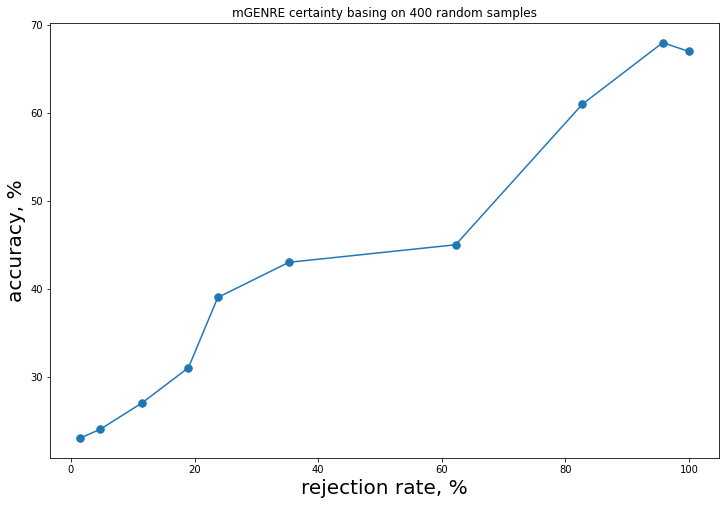

In [95]:
plt.figure(figsize = (12,8))
plt.xlabel("rejection rate, %", fontsize = 20)
plt.ylabel("accuracy, %", fontsize = 20)
plt.title("mGENRE certainty basing on 400 random samples")
plt.plot(share_of_observations_400_top_1[::-1], accuracy_400_top_1, marker = '.', markersize = 15);

# MC Dropout

In [175]:
%%writefile fairseq_model.py
# Copyright (c) Facebook, Inc. and its affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
"""
Base classes for various fairseq models.
"""

import logging
from argparse import Namespace
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from fairseq import utils
from fairseq.data import Dictionary
from fairseq.dataclass.utils import (
    convert_namespace_to_omegaconf,
    gen_parser_from_dataclass,
)
from fairseq.models import FairseqDecoder, FairseqEncoder
from omegaconf import DictConfig
from torch import Tensor


logger = logging.getLogger(__name__)


class BaseFairseqModel(nn.Module):
    """Base class for fairseq models."""

    def __init__(self):
        super().__init__()
        self._is_generation_fast = False

    @classmethod
    def add_args(cls, parser):
        """Add model-specific arguments to the parser."""
        dc = getattr(cls, "__dataclass", None)
        if dc is not None:
            # do not set defaults so that settings defaults from various architectures still works
            gen_parser_from_dataclass(parser, dc(), delete_default=True)

    @classmethod
    def build_model(cls, args, task):
        """Build a new model instance."""
        raise NotImplementedError("Model must implement the build_model method")

    def get_targets(self, sample, net_output):
        """Get targets from either the sample or the net's output."""
        return sample["target"]

    def get_normalized_probs(
        self,
        net_output: Tuple[Tensor, Optional[Dict[str, List[Optional[Tensor]]]]],
        log_probs: bool,
        sample: Optional[Dict[str, Tensor]] = None,
    ):
        """Get normalized probabilities (or log probs) from a net's output."""
        return self.get_normalized_probs_scriptable(net_output, log_probs, sample)

    # TorchScript doesn't support super() method so that the scriptable Subclass
    # can't access the base class model in Torchscript.
    # Current workaround is to add a helper function with different name and
    # call the helper function from scriptable Subclass.
    def get_normalized_probs_scriptable(
        self,
        net_output: Tuple[Tensor, Optional[Dict[str, List[Optional[Tensor]]]]],
        log_probs: bool,
        sample: Optional[Dict[str, Tensor]] = None,
    ):
        """Scriptable helper function for get_normalized_probs in ~BaseFairseqModel"""
        if hasattr(self, "decoder"):
            return self.decoder.get_normalized_probs(net_output, log_probs, sample)
        elif torch.is_tensor(net_output):
            # syntactic sugar for simple models which don't have a decoder
            # (e.g., the classification tutorial)
            logits = net_output.float()
            if log_probs:
                return F.log_softmax(logits, dim=-1)
            else:
                return F.softmax(logits, dim=-1)
        raise NotImplementedError

    def extract_features(self, *args, **kwargs):
        """Similar to *forward* but only return features."""
        return self(*args, **kwargs)

    def max_positions(self):
        """Maximum length supported by the model."""
        return None

    def load_state_dict(
        self,
        state_dict,
        strict=True,
        model_cfg: Optional[DictConfig] = None,
        args: Optional[Namespace] = None,
    ):
        """Copies parameters and buffers from *state_dict* into this module and
        its descendants.

        Overrides the method in :class:`nn.Module`. Compared with that method
        this additionally "upgrades" *state_dicts* from old checkpoints.
        """

        if model_cfg is None and args is not None:
            logger.warn("using 'args' is deprecated, please update your code to use dataclass config")
            model_cfg = convert_namespace_to_omegaconf(args).model

        self.upgrade_state_dict(state_dict)

        from fairseq.checkpoint_utils import prune_state_dict

        new_state_dict = prune_state_dict(state_dict, model_cfg)
        return super().load_state_dict(new_state_dict, strict)

    def upgrade_state_dict(self, state_dict):
        """Upgrade old state dicts to work with newer code."""
        self.upgrade_state_dict_named(state_dict, "")

    def upgrade_state_dict_named(self, state_dict, name):
        """Upgrade old state dicts to work with newer code.

        Args:
            state_dict (dict): state dictionary to upgrade, in place
            name (str): the state dict key corresponding to the current module
        """
        assert state_dict is not None

        def do_upgrade(m, prefix):
            if len(prefix) > 0:
                prefix += "."

            for n, c in m.named_children():
                name = prefix + n
                if hasattr(c, "upgrade_state_dict_named"):
                    c.upgrade_state_dict_named(state_dict, name)
                elif hasattr(c, "upgrade_state_dict"):
                    c.upgrade_state_dict(state_dict)
                do_upgrade(c, name)

        do_upgrade(self, name)

    def set_num_updates(self, num_updates):
        """State from trainer to pass along to model at every update."""

        def _apply(m):
            if hasattr(m, "set_num_updates") and m != self:
                m.set_num_updates(num_updates)

        self.apply(_apply)

    def prepare_for_inference_(self, cfg: DictConfig):
        """Prepare model for inference."""
        kwargs = {}
        kwargs["beamable_mm_beam_size"] = (
            None
            if getattr(cfg.generation, "no_beamable_mm", False)
            else getattr(cfg.generation, "beam", 5)
        )
        kwargs["need_attn"] = getattr(cfg.generation, "print_alignment", False)
        if getattr(cfg.generation, "retain_dropout", False):
            kwargs["retain_dropout"] = cfg.generation.retain_dropout
            kwargs["retain_dropout_modules"] = cfg.generation.retain_dropout_modules
        self.make_generation_fast_(**kwargs)

    def make_generation_fast_(self, **kwargs):
        """
        Legacy entry point to optimize model for faster generation.
        Prefer prepare_for_inference_.
        """
        if self._is_generation_fast:
            return  # only apply once
        self._is_generation_fast = True

        # remove weight norm from all modules in the network
        def apply_remove_weight_norm(module):
            try:
                nn.utils.remove_weight_norm(module)
            except (AttributeError, ValueError):  # this module didn't have weight norm
                return

        self.apply(apply_remove_weight_norm)

        def apply_make_generation_fast_(module, prefix):
            if len(prefix) > 0:
                prefix += "."

            base_func = BaseFairseqModel.make_generation_fast_
            for n, m in module.named_modules():
                if (
                    m != self
                    and hasattr(m, "make_generation_fast_")
                    # don't call this implementation again, e.g., if
                    # children modules also inherit from BaseFairseqModel
                    and m.make_generation_fast_.__func__ is not base_func
                ):
                    name = prefix + n
                    m.make_generation_fast_(name=name, **kwargs)

        apply_make_generation_fast_(self, "")

        def train(mode=True):
#             if mode:
#                 raise RuntimeError("cannot train after make_generation_fast")

        # this model should no longer be used for training
#        self.eval()
            self.train()
#        self.train = train

    def prepare_for_onnx_export_(self, **kwargs):
        """Make model exportable via ONNX trace."""
        seen = set()

        def apply_prepare_for_onnx_export_(module):
            if (
                module != self
                and hasattr(module, "prepare_for_onnx_export_")
                and module not in seen
            ):
                seen.add(module)
                module.prepare_for_onnx_export_(**kwargs)

        self.apply(apply_prepare_for_onnx_export_)

    @classmethod
    def from_pretrained(
        cls,
        model_name_or_path,
        checkpoint_file="model.pt",
        data_name_or_path=".",
        **kwargs,
    ):
        """
        Load a :class:`~fairseq.models.FairseqModel` from a pre-trained model
        file. Downloads and caches the pre-trained model file if needed.

        The base implementation returns a
        :class:`~fairseq.hub_utils.GeneratorHubInterface`, which can be used to
        generate translations or sample from language models. The underlying
        :class:`~fairseq.models.FairseqModel` can be accessed via the
        *generator.models* attribute.

        Other models may override this to implement custom hub interfaces.

        Args:
            model_name_or_path (str): either the name of a pre-trained model to
                load or a path/URL to a pre-trained model state dict
            checkpoint_file (str, optional): colon-separated list of checkpoint
                files in the model archive to ensemble (default: 'model.pt')
            data_name_or_path (str, optional): point args.data to the archive
                at the given path/URL. Can start with '.' or './' to reuse the
                model archive path.
        """
        from fairseq import hub_utils

        x = hub_utils.from_pretrained(
            model_name_or_path,
            checkpoint_file,
            data_name_or_path,
            archive_map=cls.hub_models(),
            **kwargs,
        )
        logger.info(x["args"])
        return hub_utils.GeneratorHubInterface(x["args"], x["task"], x["models"])

    @classmethod
    def hub_models(cls):
        return {}


class FairseqEncoderDecoderModel(BaseFairseqModel):
    """Base class for encoder-decoder models.

    Args:
        encoder (FairseqEncoder): the encoder
        decoder (FairseqDecoder): the decoder
    """

    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        assert isinstance(self.encoder, FairseqEncoder)
        assert isinstance(self.decoder, FairseqDecoder)

    def forward(self, src_tokens, src_lengths, prev_output_tokens, **kwargs):
        """
        Run the forward pass for an encoder-decoder model.

        First feed a batch of source tokens through the encoder. Then, feed the
        encoder output and previous decoder outputs (i.e., teacher forcing) to
        the decoder to produce the next outputs::

            encoder_out = self.encoder(src_tokens, src_lengths)
            return self.decoder(prev_output_tokens, encoder_out)

        Args:
            src_tokens (LongTensor): tokens in the source language of shape
                `(batch, src_len)`
            src_lengths (LongTensor): source sentence lengths of shape `(batch)`
            prev_output_tokens (LongTensor): previous decoder outputs of shape
                `(batch, tgt_len)`, for teacher forcing

        Returns:
            tuple:
                - the decoder's output of shape `(batch, tgt_len, vocab)`
                - a dictionary with any model-specific outputs
        """
        encoder_out = self.encoder(src_tokens, src_lengths=src_lengths, **kwargs)
        decoder_out = self.decoder(
            prev_output_tokens, encoder_out=encoder_out, **kwargs
        )
        return decoder_out

    def forward_decoder(self, prev_output_tokens, **kwargs):
        return self.decoder(prev_output_tokens, **kwargs)

    def extract_features(self, src_tokens, src_lengths, prev_output_tokens, **kwargs):
        """
        Similar to *forward* but only return features.

        Returns:
            tuple:
                - the decoder's features of shape `(batch, tgt_len, embed_dim)`
                - a dictionary with any model-specific outputs
        """
        encoder_out = self.encoder(src_tokens, src_lengths=src_lengths, **kwargs)
        features = self.decoder.extract_features(
            prev_output_tokens, encoder_out=encoder_out, **kwargs
        )
        return features

    def output_layer(self, features, **kwargs):
        """Project features to the default output size (typically vocabulary size)."""
        return self.decoder.output_layer(features, **kwargs)

    def max_positions(self):
        """Maximum length supported by the model."""
        return (self.encoder.max_positions(), self.decoder.max_positions())

    def max_decoder_positions(self):
        """Maximum length supported by the decoder."""
        return self.decoder.max_positions()


class FairseqModel(FairseqEncoderDecoderModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        utils.deprecation_warning(
            "FairseqModel is deprecated, please use FairseqEncoderDecoderModel "
            "or BaseFairseqModel instead",
            stacklevel=4,
        )


class FairseqMultiModel(BaseFairseqModel):
    """Base class for combining multiple encoder-decoder models."""

    def __init__(self, encoders, decoders):
        super().__init__()
        assert encoders.keys() == decoders.keys()
        self.keys = list(encoders.keys())
        for key in self.keys:
            assert isinstance(encoders[key], FairseqEncoder)
            assert isinstance(decoders[key], FairseqDecoder)

        self.models = nn.ModuleDict(
            {
                key: FairseqEncoderDecoderModel(encoders[key], decoders[key])
                for key in self.keys
            }
        )

    @staticmethod
    def build_shared_embeddings(
        dicts: Dict[str, Dictionary],
        langs: List[str],
        embed_dim: int,
        build_embedding: callable,
        pretrained_embed_path: Optional[str] = None,
    ):
        """
        Helper function to build shared embeddings for a set of languages after
        checking that all dicts corresponding to those languages are equivalent.

        Args:
            dicts: Dict of lang_id to its corresponding Dictionary
            langs: languages that we want to share embeddings for
            embed_dim: embedding dimension
            build_embedding: callable function to actually build the embedding
            pretrained_embed_path: Optional path to load pretrained embeddings
        """
        shared_dict = dicts[langs[0]]
        if any(dicts[lang] != shared_dict for lang in langs):
            raise ValueError(
                "--share-*-embeddings requires a joined dictionary: "
                "--share-encoder-embeddings requires a joined source "
                "dictionary, --share-decoder-embeddings requires a joined "
                "target dictionary, and --share-all-embeddings requires a "
                "joint source + target dictionary."
            )
        return build_embedding(shared_dict, embed_dim, pretrained_embed_path)

    def forward(self, src_tokens, src_lengths, prev_output_tokens, **kwargs):
        raise NotImplementedError

    def max_positions(self):
        """Maximum length supported by the model."""
        return {
            key: (
                self.models[key].encoder.max_positions(),
                self.models[key].decoder.max_positions(),
            )
            for key in self.keys
        }

    def max_decoder_positions(self):
        """Maximum length supported by the decoder."""
        return min(model.decoder.max_positions() for model in self.models.values())

    @property
    def encoder(self):
        return self.models[self.keys[0]].encoder

    @property
    def decoder(self):
        return self.models[self.keys[0]].decoder

    def forward_decoder(self, prev_output_tokens, **kwargs):
        return self.decoder(prev_output_tokens, **kwargs)

    def load_state_dict(
        self,
        state_dict,
        strict=True,
        model_cfg=None,
        args: Optional[Namespace] = None,
    ):
        """Copies parameters and buffers from *state_dict* into this module and
        its descendants.

        Overrides the method in :class:`nn.Module`. Compared with that method
        this additionally "upgrades" *state_dicts* from old checkpoints.
        """

        if model_cfg is None and args is not None:
            logger.warn("using 'args' is deprecated, please update your code to use dataclass config")
            model_cfg = convert_namespace_to_omegaconf(args).model

        self.upgrade_state_dict(state_dict)

        from fairseq.checkpoint_utils import prune_state_dict

        new_state_dict = prune_state_dict(state_dict, model_cfg)
        return super().load_state_dict(new_state_dict, strict)


class FairseqLanguageModel(BaseFairseqModel):
    """Base class for decoder-only models.

    Args:
        decoder (FairseqDecoder): the decoder
    """

    def __init__(self, decoder):
        super().__init__()
        self.decoder = decoder
        assert isinstance(self.decoder, FairseqDecoder)

    def forward(self, src_tokens, **kwargs):
        """
        Run the forward pass for a decoder-only model.

        Feeds a batch of tokens through the decoder to predict the next tokens.

        Args:
            src_tokens (LongTensor): tokens on which to condition the decoder,
                of shape `(batch, tgt_len)`
            src_lengths (LongTensor): source sentence lengths of shape `(batch)`

        Returns:
            tuple:
                - the decoder's output of shape `(batch, seq_len, vocab)`
                - a dictionary with any model-specific outputs
        """
        return self.decoder(src_tokens, **kwargs)

    def forward_decoder(self, prev_output_tokens, **kwargs):
        return self.decoder(prev_output_tokens, **kwargs)

    def extract_features(self, src_tokens, **kwargs):
        """
        Similar to *forward* but only return features.

        Returns:
            tuple:
                - the decoder's features of shape `(batch, seq_len, embed_dim)`
                - a dictionary with any model-specific outputs
        """
        return self.decoder.extract_features(src_tokens, **kwargs)

    def output_layer(self, features, **kwargs):
        """Project features to the default output size (typically vocabulary size)."""
        return self.decoder.output_layer(features, **kwargs)

    def max_positions(self):
        """Maximum length supported by the model."""
        return self.decoder.max_positions()

    def max_decoder_positions(self):
        """Maximum length supported by the decoder."""
        return self.decoder.max_positions()

    @property
    def supported_targets(self):
        return {"future"}


class FairseqEncoderModel(BaseFairseqModel):
    """Base class for encoder-only models.

    Args:
        encoder (FairseqEncoder): the encoder
    """

    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        assert isinstance(self.encoder, FairseqEncoder)

    def forward(self, src_tokens, src_lengths, **kwargs):
        """
        Run the forward pass for a encoder-only model.

        Feeds a batch of tokens through the encoder to generate features.

        Args:
            src_tokens (LongTensor): input tokens of shape `(batch, src_len)`
            src_lengths (LongTensor): source sentence lengths of shape `(batch)`

        Returns:
            the encoder's output, typically of shape `(batch, src_len, features)`
        """
        return self.encoder(src_tokens, src_lengths, **kwargs)

    def get_normalized_probs(self, net_output, log_probs, sample=None):
        """Get normalized probabilities (or log probs) from a net's output."""
        encoder_out = net_output["encoder_out"]
        if torch.is_tensor(encoder_out):
            logits = encoder_out.float()
            if log_probs:
                return F.log_softmax(logits, dim=-1)
            else:
                return F.softmax(logits, dim=-1)
        raise NotImplementedError

    def max_positions(self):
        """Maximum length supported by the model."""
        return self.encoder.max_positions()


Writing fairseq_model.py


In [176]:
%mv fairseq_model.py fairseq/fairseq/models

In [169]:
gc.collect()
torch.cuda.empty_cache()

In [177]:
!nvidia-cdl

Driver version: 495.29.05
------------------- Device 0 -------------------
Name: NVIDIA GeForce RTX 3090
Memory usage: 24237MiB / 24268MiB
Temperature: 24C
Running processes not found

------------------- Device 1 -------------------
Name: NVIDIA GeForce RTX 3090
Memory usage: 24250MiB / 24268MiB
Temperature: 65C
Running processes not found

------------------- Device 2 -------------------
Name: NVIDIA GeForce RTX 3090
Memory usage: 23173MiB / 24268MiB
Temperature: 20C
Running processes not found

------------------- Device 3 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:  9471MiB / 11019MiB
Temperature: 21C
Running processes not found

------------------- Device 4 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage: 11014MiB / 11019MiB
Temperature: 23C
Running processes not found



In [167]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [168]:
# generate Wikipedia titles and language IDs
model_mGENRE_mcdropout = mGENRE.from_pretrained("fairseq_multilingual_entity_disambiguation").train()
model_mGENRE_mcdropout.to(device)

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 1; 23.70 GiB total capacity; 3.76 GiB already allocated; 17.69 MiB free; 3.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
model_mGENRE_mcdropout

In [156]:
from fairseq.modules.fairseq_dropout import FairseqDropout

In [157]:
FairseqDropout(p = 0.2)

FairseqDropout()

In [140]:
model_mGENRE_mcdropout.models[0].encoder.dropout_module.forward(torch.ones(100))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [141]:
torch.ones(100)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# NER + MEL

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")

nlp = pipeline("ner", model=model, tokenizer=tokenizer,)



In [ ]:
questions = ["Who is Pushkin?",
             "Is Pushkinskaya metro station located in Saint Petersburg?",
             "Is Saint Petersburg located on Mississipi?",
             
             "Did Stephen Hawking discover theory of relativity?",
             
             "When Caesar was an imperor of the Roman empire?",
             "How many times have people won the jackpot at Caesar?",
             "Is Caesar a part of the Italian national cuisine?",
             
             "What did Tsiolkovsky invent?",
             
             "Was George Washington the first American President?",
             "Does Denver State border Washington State?",
             "How long Alexander Ovechkin play for Washington Capitals?"]



In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

class NER:
    def __init__(self, 
                 #text, 
                 model = "Babelscape/wikineural-multilingual-ner",
                 tokenizer = "Babelscape/wikineural-multilingual-ner"):
        
        #self.text = text
        self.model = model
        self.tokenizer = tokenizer
    
    def set_pipeline(self):   
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer)
        self.model = AutoModelForTokenClassification.from_pretrained(self.model)
        self.nlp = pipeline("ner",
                            model = self.model,
                            tokenizer = self.tokenizer)
        
    def receive_text(self, text):
        self.text = text
    
    def receive_words(self):
        self.text = re.sub('[!@#$?,]', '', self.text)
        out = re.split(r' ', self.text)
        return out
    
    
    def receive_enitity(self):
        ner_results = self.nlp(self.text)
        final = []
        result = [i["word"] for i in ner_results]
        for elem in result:    
            if elem[:2] == "##":
                final[-1] = final[-1] + elem[2:]
            else:
                final.append(elem)
        return final
    
    def text_with_marked_entities(self):
        output = ""
        entities = self.receive_enitity()
        list_of_words = self.receive_words()
        for word in list_of_words:
            if word not in entities:
                output = output + word + " "
            else:
                output = output + "[START] " + word +  " [END] "
        output = re.sub("\[END\] \[START\] ", "", output)
        output += "?"
        return output
    
    
        
    
    
  

In [56]:
#ner = NER(text = "How many times have people won the jackpot at Caesar?")

# initialize class
ner = NER()

# establish pipeline
ner.set_pipeline()

# load text
ner.receive_text(text = "How many times have people won the jackpot at Caesar?")

# receive text with marked entities
output = ner.text_with_marked_entities()
output

'How many times have people won the jackpot at [START] Caesar [END] ?'

In [63]:
changed_texts = []
for question in questions:
    print("Initial question: \n", question)
    
    ner.receive_text(text = question)
    
    new_text = ner.text_with_marked_entities()
    changed_texts.append(new_text)
    print("NER over initial question: \n", new_text)
    
    print("\n")
    print("#"*100)

Initial question: 
 Who is Pushkin?
NER over initial question: 
 Who is [START] Pushkin [END] ?


####################################################################################################
Initial question: 
 Is Pushkinskaya metro station located in Saint Petersburg?
NER over initial question: 
 Is [START] Pushkinskaya [END] metro station located in [START] Saint Petersburg [END] ?


####################################################################################################
Initial question: 
 Is Saint Petersburg located on Mississipi?
NER over initial question: 
 Is [START] Saint Petersburg [END] located on [START] Mississipi [END] ?


####################################################################################################
Initial question: 
 Did Stephen Hawking discover theory of relativity?
NER over initial question: 
 Did [START] Stephen Hawking [END] discover theory of relativity ?


###################################################################

In [64]:
changed_texts

['Who is [START] Pushkin [END] ?',
 'Is [START] Pushkinskaya [END] metro station located in [START] Saint Petersburg [END] ?',
 'Is [START] Saint Petersburg [END] located on [START] Mississipi [END] ?',
 'Did [START] Stephen Hawking [END] discover theory of relativity ?',
 'When [START] Caesar [END] was an imperor of the [START] Roman [END] empire ?',
 'How many times have people won the jackpot at [START] Caesar [END] ?',
 'Is [START] Caesar [END] a part of the [START] Italian [END] national cuisine ?',
 'What did [START] Tsiolkovsky [END] invent ?',
 'Was [START] George Washington [END] the first [START] American [END] President ?',
 'Does [START] Denver State [END] border [START] Washington State [END] ?',
 'How long [START] Alexander Ovechkin [END] play for [START] Washington Capitals [END] ?']

In [65]:
sentences = [changed_texts[0]]
model_mGENRE.sample(
    sentences,
    beam = 5,
    prefix_allowed_tokens_fn=lambda batch_id, sent: [
        e for e in trie.get(sent.tolist())
        if e < len(model_mGENRE.task.target_dictionary)
    ],
    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
    marginalize=True,
    verbose = True
)

[[{'id': 'Q7200',
   'texts': ['Alexander Pushkin >> en',
    'Aleksandr Pushkin >> en',
    'Alexandr Pushkin >> en',
    'Pushkin >> en',
    'Aleksandr Pushkin >> es'],
   'scores': tensor([-0.0850, -0.7231, -0.8690, -0.9665, -0.9766], device='cuda:4'),
   'score': tensor(0.2237, device='cuda:4')}]]

In [69]:
for i in range(len(changed_texts)):
    sentences = [changed_texts[i]]
    print(model_mGENRE.sample(
        sentences,
        beam = 5,
        prefix_allowed_tokens_fn=lambda batch_id, sent: [
            e for e in trie.get(sent.tolist())
            if e < len(model_mGENRE.task.target_dictionary)
        ],
        text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
        marginalize=True,
        verbose = True
    ))
    print("\n")

[[{'id': 'Q7200', 'texts': ['Alexander Pushkin >> en', 'Aleksandr Pushkin >> en', 'Alexandr Pushkin >> en', 'Pushkin >> en', 'Aleksandr Pushkin >> es'], 'scores': tensor([-0.0850, -0.7231, -0.8690, -0.9665, -0.9766], device='cuda:4'), 'score': tensor(0.2237, device='cuda:4')}]]


[[{'id': 'Q2079447', 'texts': ['Pushkinskaya (Saint Petersburg Metro) >> en'], 'scores': tensor([-0.1192], device='cuda:4'), 'score': tensor(-0.3955, device='cuda:4')}, {'id': 'Q1627587', 'texts': ['Pushkinskaya (Moscow Metro) >> en'], 'scores': tensor([-0.2643], device='cuda:4'), 'score': tensor(-0.9156, device='cuda:4')}, {'id': 'Q7261815', 'texts': ['Pushkinskaya >> en'], 'scores': tensor([-0.8117], device='cuda:4'), 'score': tensor(-1.9882, device='cuda:4')}, {'id': 'Q2444846', 'texts': ['Pushkinskaya (Minsk Metro) >> en'], 'scores': tensor([-0.6415], device='cuda:4'), 'score': tensor(-2.1277, device='cuda:4')}, {'id': 'Q250225', 'texts': ['Saint Petersburg Metro >> en'], 'scores': tensor([-0.9126], device

In [99]:
data = [["Q16330302", "P19", "Q1524", "what city was alex golfis born in"],
        ["Q16225521", "R58", "Q192979", "what film is by the writer phil hay?"],
        ["Q7358590", "P20", "Q1637790", "Where did roger marquis die"],
        ["Q154335", "P509", "Q12152", "what was the cause of death of yves klein"],
        ["Q1761", "R19", "Q6768445", "Which equestrian was born in dublin?"],
        ["Q11272426", "R136", "Q5533291", "What is a tv action show?"],
        ["Q2581168", "P172", "Q810714", "what's akbar tandjung's ethnicity"],
        ["Q2747238", "P413", "Q5059480", "What position does carlos gomez play?"],
        ["Q62498", "P21", "Q6581097", "how does engelbert zaschka identify"],
        ["Q182485", "P413", "Q1143358", "what position does pee wee reese play in baseball"],
        ["Q12152", "R509", "Q6371569", "Which Swiss conductor's cause of death is myocardial infarction?"],
        ["Q1176417", "P136", "Q37073", "what type of music does david ruffin play"],
        ["Q7123909", "P20", "Q3130", "where was padraic mcguinness's place of death"],
        ["Q1189775", "P364", "Q1860", "what language is viper in"],
        ["Q276817", "P737", "Q169566", "Who influenced michael mcdowell?"],
        ["Q472382", "P19", "Q23051", "what is the place of birth of sam edwards?"],
        ["Q7443093", "P710", "Q214102", "which military was involved in the second battle of fort fisher"]]

In [96]:
# initialize class
method = "aubmindlab/araelectra-base-generator"

ner = NER(model = method,
          tokenizer = method)

# establish pipeline
ner.set_pipeline()


# NER
changed_texts = []
for question in data:
    print("Initial question: \n", question[3])
    
    # load text
    ner.receive_text(text = question[3])
    
    # receive text with marked entities
    new_text = ner.text_with_marked_entities()
    changed_texts.append(new_text)
    print("NER over initial question: \n", new_text)
    
    print("\n")
    print("#"*100)

Some weights of the model checkpoint at aubmindlab/araelectra-base-generator were not used when initializing ElectraForTokenClassification: ['generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_lm_head.weight', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at aubmindlab/araelectra-base-generator and are newly initializ

Initial question: 
 what city was alex golfis born in
NER over initial question: 
 [START] what city was alex golfis born in [END] ?


####################################################################################################
Initial question: 
 what film is by the writer phil hay?
NER over initial question: 
 [START] what film is by the writer phil hay [END] ?


####################################################################################################
Initial question: 
 Where did roger marquis die
NER over initial question: 
 [START] Where did roger marquis die [END] ?


####################################################################################################
Initial question: 
 what was the cause of death of yves klein
NER over initial question: 
 [START] what was the cause of death of yves klein [END] ?


####################################################################################################
Initial question: 
 Which equestrian was born i

In [98]:
!pip install deeppavlov

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 878.6/878.6 kB 4.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 39.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 70.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 62.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 47.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 51.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 64.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [97]:
from deeppavlov import configs, build_model

ner_model = build_model(configs.ner.ner_ontonotes_bert_mult, download=True)
#ner_model(['World Curling Championship will be held in Antananarivo'])

ModuleNotFoundError: No module named 'deeppavlov'

In [106]:
for i in data:   
    sentences = [i[3]]
    print(i[3])
    print("\n")
    print(model_mGENRE.sample(
        sentences,
        beam = 5,
        prefix_allowed_tokens_fn=lambda batch_id, sent: [
            e for e in trie.get(sent.tolist())
            if e < len(model_mGENRE.task.target_dictionary)
        ],
        text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
        marginalize=True,
        verbose = True
    ))
    print("\n")
    print("true answer object: ", i[0])
    print("true answer subject: ", i[2])
    
    print("\n")
    print("#"*20)

what city was alex golfis born in


[[{'id': 'Q3561', 'texts': ['Algiers >> en'], 'scores': tensor([-0.7752], device='cuda:4'), 'score': tensor(-1.8988, device='cuda:4')}, {'id': 'Q994', 'texts': ['Tiflis >> en', 'Tbilisi >> en'], 'scores': tensor([-1.1594, -1.1623], device='cuda:4'), 'score': tensor(-2.0191, device='cuda:4')}, {'id': 'Q6343', 'texts': ['Carthage >> en'], 'scores': tensor([-0.9458], device='cuda:4'), 'score': tensor(-2.3167, device='cuda:4')}, {'id': 'Q5818', 'texts': ['Córdoba, Spain >> en'], 'scores': tensor([-0.8913], device='cuda:4'), 'score': tensor(-2.5210, device='cuda:4')}]]


true answer object:  Q16330302
true answer subject:  Q1524


####################
what film is by the writer phil hay?


[[{'id': 'Q26786240', 'texts': ['Phil Hay >> en'], 'scores': tensor([-0.2330], device='cuda:4'), 'score': tensor(-0.5211, device='cuda:4')}, {'id': 'Q374585', 'texts': ['Phil Hayes >> en'], 'scores': tensor([-0.5991], device='cuda:4'), 'score': tensor(-1.4675, device='c

# Quantitative assessment on Simple Questions

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

class NER:
    def __init__(self, 
                 #text, 
                 model = "Babelscape/wikineural-multilingual-ner",
                 tokenizer = "Babelscape/wikineural-multilingual-ner"):
        
        #self.text = text
        self.model = model
        self.tokenizer = tokenizer
    
    def set_pipeline(self):   
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer)
        self.model = AutoModelForTokenClassification.from_pretrained(self.model)
        self.nlp = pipeline("ner",
                            model = self.model,
                            tokenizer = self.tokenizer)
        
    def receive_text(self, text):
        self.text = text
    
    def receive_words(self):
        self.text = re.sub('[!@#$?,]', '', self.text)
        out = re.split(r' ', self.text)
        return out
    
    
    def receive_enitity(self):
        ner_results = self.nlp(self.text)
        print("ner_results", ner_results)
        final = []
        result = [i["word"] for i in ner_results]
        for elem in result:
            print("elem", elem)
            if (elem[:2] == "##") & (len(final) > 0):
                final[-1] = final[-1] + elem[2:]
            elif elem[:2] == "##":
                final.append(elem[2:])
            else:
                final.append(elem)
        return final
    
    def text_with_marked_entities(self):
        output = ""
        entities = self.receive_enitity()
        list_of_words = self.receive_words()
        for word in list_of_words:
            if word not in entities:
                output = output + word + " "
            else:
                output = output + "[START] " + word +  " [END] "
        output = re.sub("\[END\] \[START\] ", "", output)
        output += "?"
        return output
    
    
        
    
    
  

In [ ]:
#ner = NER(text = "How many times have people won the jackpot at Caesar?")

# initialize class
ner = NER()

# establish pipeline
ner.set_pipeline()


In [ ]:
texts = list(data.sample(n = n, replace = False, random_state=1).loc[:, "question"])

In [ ]:
from tqdm import tqdm

In [53]:
# NER
changed_texts = []
for question in tqdm(texts):
    print("Initial question: \n", question)
    
    # load text
    ner.receive_text(text = question)
    
    # receive text with marked entities
    new_text = ner.text_with_marked_entities()
    changed_texts.append(new_text)
    print("NER over initial question: \n", new_text)
    
    print("\n")
    print("#"*100)

  1%|          | 3/400 [00:00<00:15, 25.53it/s]

Initial question: 
 What is a movie pierce brosnan produced?
ner_results []
NER over initial question: 
 What is a movie pierce brosnan produced ?


####################################################################################################
Initial question: 
 What kind of music is featured on ten new songs
ner_results []
NER over initial question: 
 What kind of music is featured on ten new songs ?


####################################################################################################
Initial question: 
 which episode was written by chris carter (screenwriter)
ner_results [{'word': 'ch', 'score': 0.6152981519699097, 'entity': 'B-ORG', 'index': 6, 'start': 29, 'end': 31}]
elem ch
NER over initial question: 
 which episode was written by chris carter (screenwriter) ?


####################################################################################################
Initial question: 
 What kind of celestial object is 1495 helsinki?
ner_results [{'word': 'hel',

  2%|▏         | 6/400 [00:01<01:24,  4.69it/s]

ner_results [{'word': 'af', 'score': 0.7936720848083496, 'entity': 'B-MISC', 'index': 4, 'start': 10, 'end': 12}, {'word': '##rica', 'score': 0.6354202032089233, 'entity': 'B-MISC', 'index': 5, 'start': 12, 'end': 16}, {'word': '##n', 'score': 0.5097811222076416, 'entity': 'B-MISC', 'index': 6, 'start': 16, 'end': 17}, {'word': 'american', 'score': 0.609046459197998, 'entity': 'B-MISC', 'index': 7, 'start': 18, 'end': 26}]
elem af
elem ##rica
elem ##n
elem american
NER over initial question: 
 Who is an [START] african american [END] character actor and retired professional wrestler  ?


####################################################################################################
Initial question: 
 Name a professional writer


  2%|▏         | 8/400 [00:01<01:14,  5.26it/s]

ner_results []
NER over initial question: 
 Name a professional writer ?


####################################################################################################
Initial question: 
 Which country is marcel landers from?
ner_results []
NER over initial question: 
 Which country is marcel landers from ?


####################################################################################################
Initial question: 
 what is an example of a city that can be found in  north american central time zone


  2%|▎         | 10/400 [00:02<01:36,  4.06it/s]

ner_results [{'word': 'american', 'score': 0.7435474395751953, 'entity': 'B-MISC', 'index': 14, 'start': 57, 'end': 65}]
elem american
NER over initial question: 
 what is an example of a city that can be found in  north [START] american [END] central time zone ?


####################################################################################################
Initial question: 
 In what language was inside man filmed?
ner_results []
NER over initial question: 
 In what language was inside man filmed ?


####################################################################################################
Initial question: 
 what genre is serpico in?


  4%|▍         | 15/400 [00:02<00:42,  8.96it/s]

ner_results []
NER over initial question: 
 what genre is serpico in ?


####################################################################################################
Initial question: 
 What type of music is bobby kildea known for
ner_results [{'word': 'bob', 'score': 0.6602774858474731, 'entity': 'B-MISC', 'index': 6, 'start': 22, 'end': 25}, {'word': '##by', 'score': 0.5224658250808716, 'entity': 'I-MISC', 'index': 7, 'start': 25, 'end': 27}, {'word': 'ki', 'score': 0.6515940427780151, 'entity': 'B-MISC', 'index': 8, 'start': 28, 'end': 30}, {'word': '##lde', 'score': 0.38386669754981995, 'entity': 'I-MISC', 'index': 9, 'start': 30, 'end': 33}, {'word': '##a', 'score': 0.6285944581031799, 'entity': 'I-MISC', 'index': 10, 'start': 33, 'end': 34}]
elem bob
elem ##by
elem ki
elem ##lde
elem ##a
NER over initial question: 
 What type of music is [START] bobby kildea [END] known for ?


###############################################################################################

  5%|▌         | 20/400 [00:03<00:41,  9.05it/s]

ner_results [{'word': 'Yo', 'score': 0.9951897263526917, 'entity': 'B-MISC', 'index': 10, 'start': 47, 'end': 49}, {'word': '##shi', 'score': 0.9979313611984253, 'entity': 'I-MISC', 'index': 11, 'start': 49, 'end': 52}, {'word': '##s', 'score': 0.9992203712463379, 'entity': 'I-MISC', 'index': 12, 'start': 52, 'end': 53}, {'word': 'Safari', 'score': 0.9970843195915222, 'entity': 'I-MISC', 'index': 13, 'start': 54, 'end': 60}]
elem Yo
elem ##shi
elem ##s
elem Safari
NER over initial question: 
 What game play mode is the computer video game [START] Yoshis Safari [END] ?


####################################################################################################
Initial question: 
 Where exactly was marian goliński born
ner_results [{'word': 'mari', 'score': 0.8758665919303894, 'entity': 'B-PER', 'index': 4, 'start': 18, 'end': 22}, {'word': '##an', 'score': 0.6453502178192139, 'entity': 'I-PER', 'index': 5, 'start': 22, 'end': 24}, {'word': 'goli', 'score': 0.56134033203125, 'e

  6%|▋         | 25/400 [00:03<00:29, 12.81it/s]

ner_results [{'word': 'li', 'score': 0.6235854625701904, 'entity': 'B-LOC', 'index': 5, 'start': 18, 'end': 20}]
elem li
NER over initial question: 
 what time zone is lindstrom in ?


####################################################################################################
Initial question: 
 what is mohamed safwat's gender
ner_results []
NER over initial question: 
 what is mohamed safwat's gender ?


####################################################################################################
Initial question: 
 which german city is faiz kevin mangat from
ner_results [{'word': 'german', 'score': 0.950069785118103, 'entity': 'B-MISC', 'index': 2, 'start': 6, 'end': 12}]
elem german
NER over initial question: 
 which [START] german [END] city is faiz kevin mangat from ?


####################################################################################################
Initial question: 
 What nation is tulsi ramsay from?
ner_results [{'word': 'tu', 'score': 0.3969

  7%|▋         | 28/400 [00:03<00:25, 14.49it/s]

ner_results [{'word': 'son', 'score': 0.9524672031402588, 'entity': 'B-PER', 'index': 3, 'start': 8, 'end': 11}, {'word': '##ja', 'score': 0.7951620817184448, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 13}, {'word': 'ska', 'score': 0.9669378995895386, 'entity': 'I-PER', 'index': 5, 'start': 14, 'end': 17}, {'word': '##rst', 'score': 0.9139488339424133, 'entity': 'I-PER', 'index': 6, 'start': 17, 'end': 20}, {'word': '##edt', 'score': 0.8780090808868408, 'entity': 'I-PER', 'index': 7, 'start': 20, 'end': 23}]
elem son
elem ##ja
elem ska
elem ##rst
elem ##edt
NER over initial question: 
 what is [START] sonja [END] skarstedt's place of birth ?


####################################################################################################
Initial question: 
 who is someone born in barcelona
ner_results [{'word': 'bar', 'score': 0.4818287789821625, 'entity': 'B-LOC', 'index': 6, 'start': 23, 'end': 26}, {'word': '##cel', 'score': 0.39018744230270386, 'entity': 'I-LOC', 'inde

  8%|▊         | 34/400 [00:03<00:20, 17.92it/s]

ner_results [{'word': 'thi', 'score': 0.836921751499176, 'entity': 'B-PER', 'index': 6, 'start': 15, 'end': 18}, {'word': '##lo', 'score': 0.5845729112625122, 'entity': 'I-PER', 'index': 7, 'start': 18, 'end': 20}, {'word': 'kl', 'score': 0.5662601590156555, 'entity': 'I-PER', 'index': 8, 'start': 21, 'end': 23}]
elem thi
elem ##lo
elem kl
NER over initial question: 
 Which city was [START] thilo [END] kleibauer born in ?


####################################################################################################
Initial question: 
 who is a parent of casey johnson
ner_results [{'word': 'case', 'score': 0.5049830079078674, 'entity': 'B-MISC', 'index': 6, 'start': 19, 'end': 23}]
elem case
NER over initial question: 
 who is a parent of casey johnson ?


####################################################################################################
Initial question: 
 which artist records under columbia records
ner_results [{'word': 'col', 'score': 0.5369917154312134, 'en

  9%|▉         | 37/400 [00:03<00:24, 15.00it/s]

ner_results [{'word': 'ear', 'score': 0.8605076670646667, 'entity': 'B-ORG', 'index': 6, 'start': 31, 'end': 34}, {'word': '##ache', 'score': 0.8077614903450012, 'entity': 'I-ORG', 'index': 7, 'start': 34, 'end': 38}]
elem ear
elem ##ache
NER over initial question: 
 which artist records under the [START] earache [END] records label ?


####################################################################################################
Initial question: 
 This jazz was released in 1959.


 10%|▉         | 39/400 [00:04<00:40,  9.02it/s]

ner_results [{'word': 'jazz', 'score': 0.6714209914207458, 'entity': 'B-MISC', 'index': 2, 'start': 5, 'end': 9}]
elem jazz
NER over initial question: 
 This [START] jazz [END] was released in 1959. ?


####################################################################################################
Initial question: 
 what does 1255 schilowa orbit
ner_results [{'word': '##a', 'score': 0.4741567075252533, 'entity': 'I-LOC', 'index': 7, 'start': 22, 'end': 23}]
elem ##a
NER over initial question: 
 what does 1255 schilowa orbit ?


####################################################################################################
Initial question: 
 what games were published by ea sports


 11%|█         | 44/400 [00:04<00:32, 10.94it/s]

ner_results [{'word': 'ea', 'score': 0.9060685038566589, 'entity': 'B-ORG', 'index': 6, 'start': 29, 'end': 31}]
elem ea
NER over initial question: 
 what games were published by [START] ea [END] sports ?


####################################################################################################
Initial question: 
 Who is a missionary that was buried in highgate cemetery
ner_results [{'word': 'high', 'score': 0.5930889248847961, 'entity': 'B-LOC', 'index': 9, 'start': 39, 'end': 43}]
elem high
NER over initial question: 
 Who is a missionary that was buried in highgate cemetery ?


####################################################################################################
Initial question: 
 Which city was robert s. langer born in
ner_results [{'word': 'robe', 'score': 0.9190661907196045, 'entity': 'B-PER', 'index': 6, 'start': 15, 'end': 19}, {'word': '##rt', 'score': 0.8464214205741882, 'entity': 'I-PER', 'index': 7, 'start': 19, 'end': 21}, {'word': 's', 'score':

 12%|█▏        | 46/400 [00:05<00:32, 11.02it/s]

ner_results [{'word': 'will', 'score': 0.41644400358200073, 'entity': 'B-PER', 'index': 4, 'start': 15, 'end': 19}]
elem will
NER over initial question: 
 which city was william grant stairs born ?


####################################################################################################
Initial question: 
 who wrote city of women
ner_results []
NER over initial question: 
 who wrote city of women ?


####################################################################################################
Initial question: 
 where was carolyn mitchell born?


 12%|█▏        | 48/400 [00:05<00:35,  9.99it/s]

ner_results [{'word': 'car', 'score': 0.895651638507843, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 13}, {'word': '##ol', 'score': 0.8396389484405518, 'entity': 'I-PER', 'index': 4, 'start': 13, 'end': 15}, {'word': '##yn', 'score': 0.9128303527832031, 'entity': 'I-PER', 'index': 5, 'start': 15, 'end': 17}]
elem car
elem ##ol
elem ##yn
NER over initial question: 
 where was [START] carolyn [END] mitchell born ?


####################################################################################################
Initial question: 
 in what language was earthlings filmed
ner_results []
NER over initial question: 
 in what language was earthlings filmed ?


####################################################################################################
Initial question: 
 Who was born in greenville, south carolina?


 12%|█▎        | 50/400 [00:05<00:31, 10.99it/s]

ner_results [{'word': 'green', 'score': 0.6822827458381653, 'entity': 'B-LOC', 'index': 5, 'start': 16, 'end': 21}, {'word': 'car', 'score': 0.5034179091453552, 'entity': 'B-LOC', 'index': 9, 'start': 34, 'end': 37}]
elem green
elem car
NER over initial question: 
 Who was born in greenville south carolina ?


####################################################################################################
Initial question: 
 what was the gender of the fictional character barry ohanlon
ner_results [{'word': 'bar', 'score': 0.6024009585380554, 'entity': 'B-MISC', 'index': 9, 'start': 47, 'end': 50}, {'word': '##han', 'score': 0.3049720227718353, 'entity': 'B-MISC', 'index': 12, 'start': 54, 'end': 57}, {'word': '##lon', 'score': 0.29107603430747986, 'entity': 'I-MISC', 'index': 13, 'start': 57, 'end': 60}]
elem bar
elem ##han
elem ##lon
NER over initial question: 
 what was the gender of the fictional character barry ohanlon ?


#######################################################

 14%|█▍        | 55/400 [00:06<00:41,  8.34it/s]

ner_results [{'word': 'W', 'score': 0.9899585247039795, 'entity': 'B-LOC', 'index': 1, 'start': 0, 'end': 1}, {'word': '##H', 'score': 0.9522283673286438, 'entity': 'I-LOC', 'index': 2, 'start': 1, 'end': 2}, {'word': '##at', 'score': 0.9861955642700195, 'entity': 'I-LOC', 'index': 3, 'start': 2, 'end': 4}]
elem W
elem ##H
elem ##at
NER over initial question: 
 WHat's a basin country of lam ta klong river ?


####################################################################################################
Initial question: 
 Who is a publisher of the game final lap 3
ner_results []
NER over initial question: 
 Who is a publisher of the game final lap 3 ?


####################################################################################################
Initial question: 
 What is the gender of andreas leitner
ner_results [{'word': 'andre', 'score': 0.3943864405155182, 'entity': 'B-PER', 'index': 6, 'start': 22, 'end': 27}]
elem andre
NER over initial question: 
 What is the gende

 14%|█▍        | 57/400 [00:06<00:36,  9.49it/s]

ner_results []
NER over initial question: 
 whose music is in the sacrifice ?


####################################################################################################
Initial question: 
 What type of film was the film the glorious adventure
ner_results []
NER over initial question: 
 What type of film was the film the glorious adventure ?


####################################################################################################
Initial question: 
 Which language is the film germany, year zero in?


 15%|█▍        | 59/400 [00:07<01:02,  5.45it/s]

ner_results []
NER over initial question: 
 Which language is the film germany year zero in ?


####################################################################################################
Initial question: 
 What position in football does john macdonald play
ner_results [{'word': 'jo', 'score': 0.40434104204177856, 'entity': 'B-PER', 'index': 6, 'start': 31, 'end': 33}]
elem jo
NER over initial question: 
 What position in football does john macdonald play ?


####################################################################################################
Initial question: 
 which kind of rock music appears on spanish dance troupe
ner_results [{'word': 'span', 'score': 0.9920292496681213, 'entity': 'B-MISC', 'index': 8, 'start': 36, 'end': 40}, {'word': '##ish', 'score': 0.4141361713409424, 'entity': 'I-MISC', 'index': 9, 'start': 40, 'end': 43}]
elem span
elem ##ish
NER over initial question: 
 which kind of rock music appears on [START] spanish [END] dance troupe ?


###

 16%|█▌        | 62/400 [00:08<01:16,  4.41it/s]

ner_results []
NER over initial question: 
 what kind of subgenre of rock music is on trailblazer ?


####################################################################################################
Initial question: 
 What musician plays glam punk
ner_results []
NER over initial question: 
 What musician plays glam punk ?


####################################################################################################
Initial question: 
 where is the birthplace of mala


 16%|█▌        | 63/400 [00:08<01:13,  4.60it/s]

ner_results [{'word': 'mala', 'score': 0.4666701555252075, 'entity': 'B-PER', 'index': 7, 'start': 27, 'end': 31}]
elem mala
NER over initial question: 
 where is the birthplace of [START] mala [END] ?


####################################################################################################
Initial question: 
 what language is spoken in newtonin moondram vidhi?


 16%|█▌        | 64/400 [00:09<02:09,  2.58it/s]

ner_results [{'word': 'new', 'score': 0.9197072982788086, 'entity': 'B-MISC', 'index': 6, 'start': 27, 'end': 30}]
elem new
NER over initial question: 
 what language is spoken in newtonin moondram vidhi ?


####################################################################################################
Initial question: 
 what position does stephen mcgowan play 
ner_results [{'word': 'step', 'score': 0.517386257648468, 'entity': 'B-MISC', 'index': 4, 'start': 19, 'end': 23}]
elem step
NER over initial question: 
 what position does stephen mcgowan play  ?


####################################################################################################
Initial question: 
 what kind of film is the fruitful vine?


 16%|█▋        | 66/400 [00:09<01:39,  3.37it/s]

ner_results []
NER over initial question: 
 what kind of film is the fruitful vine ?


####################################################################################################
Initial question: 
 what position does footballer francis bossman play 
ner_results [{'word': 'franc', 'score': 0.8202551603317261, 'entity': 'B-MISC', 'index': 5, 'start': 30, 'end': 35}]
elem franc
NER over initial question: 
 what position does footballer francis bossman play  ?


####################################################################################################
Initial question: 
 what city is schandor kallosh from
ner_results []
NER over initial question: 
 what city is schandor kallosh from ?


####################################################################################################
Initial question: 
 What position does harizul izuan abdul rani play?


 18%|█▊        | 73/400 [00:10<00:39,  8.24it/s]

ner_results []
NER over initial question: 
 What position does harizul izuan abdul rani play ?


####################################################################################################
Initial question: 
 who is the microsoft train simulator developer
ner_results [{'word': 'micro', 'score': 0.943723201751709, 'entity': 'B-MISC', 'index': 4, 'start': 11, 'end': 16}, {'word': '##so', 'score': 0.8019287586212158, 'entity': 'I-MISC', 'index': 5, 'start': 16, 'end': 18}, {'word': '##ft', 'score': 0.910367488861084, 'entity': 'I-MISC', 'index': 6, 'start': 18, 'end': 20}]
elem micro
elem ##so
elem ##ft
NER over initial question: 
 who is the [START] microsoft [END] train simulator developer ?


####################################################################################################
Initial question: 
 what language is spoken in the clown
ner_results []
NER over initial question: 
 what language is spoken in the clown ?


##############################################

 19%|█▉        | 75/400 [00:12<01:52,  2.89it/s]

ner_results []
NER over initial question: 
 what company released fire emblem: the sacred stones ?


####################################################################################################
Initial question: 
 What type of space object is 1870 glaukos
ner_results [{'word': '1870', 'score': 0.6092402338981628, 'entity': 'B-LOC', 'index': 7, 'start': 29, 'end': 33}, {'word': 'g', 'score': 0.32340046763420105, 'entity': 'I-LOC', 'index': 8, 'start': 34, 'end': 35}, {'word': '##lau', 'score': 0.4440949857234955, 'entity': 'I-MISC', 'index': 9, 'start': 35, 'end': 38}, {'word': '##kos', 'score': 0.4502880871295929, 'entity': 'I-LOC', 'index': 10, 'start': 38, 'end': 41}]
elem 1870
elem g
elem ##lau
elem ##kos
NER over initial question: 
 What type of space object is [START] 1870 glaukos [END] ?


####################################################################################################
Initial question: 
 what is the gender of  nicole whippy


 20%|█▉        | 79/400 [00:12<01:14,  4.31it/s]

ner_results [{'word': 'nic', 'score': 0.5533607602119446, 'entity': 'B-MISC', 'index': 6, 'start': 23, 'end': 26}]
elem nic
NER over initial question: 
 what is the gender of  nicole whippy ?


####################################################################################################
Initial question: 
 who entity was involved in the war of the second coalition
ner_results []
NER over initial question: 
 who entity was involved in the war of the second coalition ?


####################################################################################################
Initial question: 
 who was the writer of the episode the jacket
ner_results [{'word': 'the', 'score': 0.6908398866653442, 'entity': 'B-MISC', 'index': 8, 'start': 34, 'end': 37}]
elem the
NER over initial question: 
 who was [START] the [END] writer of [START] the [END] episode [START] the [END] jacket ?


####################################################################################################
Initial 

 20%|██        | 81/400 [00:12<01:00,  5.25it/s]

ner_results []
NER over initial question: 
 What country was carmen originally from ?


####################################################################################################
Initial question: 
 what type of music is movin' wes?
ner_results [{'word': 'mo', 'score': 0.8373691439628601, 'entity': 'B-MISC', 'index': 6, 'start': 22, 'end': 24}, {'word': '##vin', 'score': 0.6295785903930664, 'entity': 'I-MISC', 'index': 7, 'start': 24, 'end': 27}, {'word': "'", 'score': 0.7095722556114197, 'entity': 'I-MISC', 'index': 8, 'start': 27, 'end': 28}, {'word': 'we', 'score': 0.6806068420410156, 'entity': 'I-MISC', 'index': 9, 'start': 29, 'end': 31}]
elem mo
elem ##vin
elem '
elem we
NER over initial question: 
 what type of music is movin' wes ?


####################################################################################################
Initial question: 
 what was the title of jewel's christmas album
ner_results [{'word': 'je', 'score': 0.4068068265914917, 'entity': 'B-P

 22%|██▏       | 87/400 [00:13<00:39,  7.88it/s]

ner_results []
NER over initial question: 
 Name a romance novel ?


####################################################################################################
Initial question: 
 which actress and signer was born in eugene, oregon
ner_results []
NER over initial question: 
 which actress and signer was born in eugene oregon ?


####################################################################################################
Initial question: 
 what position in football does sanders commings play 
ner_results [{'word': 'football', 'score': 0.6246776580810547, 'entity': 'B-ORG', 'index': 4, 'start': 17, 'end': 25}]
elem football
NER over initial question: 
 what position in [START] football [END] does sanders commings play  ?


####################################################################################################
Initial question: 
 which genre is raavanan
ner_results [{'word': 'ra', 'score': 0.8885257244110107, 'entity': 'B-MISC', 'index': 4, 'start': 15, 'en

 22%|██▏       | 89/400 [00:13<00:34,  9.04it/s]

ner_results [{'word': 'ji', 'score': 0.8459409475326538, 'entity': 'B-MISC', 'index': 8, 'start': 38, 'end': 40}, {'word': '##gar', 'score': 0.7563301920890808, 'entity': 'I-MISC', 'index': 9, 'start': 40, 'end': 43}, {'word': '##wala', 'score': 0.8504384160041809, 'entity': 'I-MISC', 'index': 10, 'start': 43, 'end': 47}]
elem ji
elem ##gar
elem ##wala
NER over initial question: 
 what language was spoken in the film  [START] jigarwala [END] ?


####################################################################################################
Initial question: 
 what does ivar bjørnson play for an instrument
ner_results [{'word': 'i', 'score': 0.9075009822845459, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 11}, {'word': '##var', 'score': 0.7580533027648926, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 14}, {'word': 'b', 'score': 0.7717334628105164, 'entity': 'I-PER', 'index': 5, 'start': 15, 'end': 16}, {'word': '##jø', 'score': 0.9065485000610352, 'entity': 'I-PER', 'in

 23%|██▎       | 93/400 [00:13<00:38,  7.98it/s]

ner_results [{'word': 'i', 'score': 0.3242684006690979, 'entity': 'B-MISC', 'index': 7, 'start': 22, 'end': 23}]
elem i
NER over initial question: 
 Who directed awesome; [START] i [END] fuckin' shot that ?


####################################################################################################
Initial question: 
 where is dag from 
ner_results []
NER over initial question: 
 where is dag from  ?


####################################################################################################
Initial question: 
 who are military personnel involved in world war ii
ner_results []
NER over initial question: 
 who are military personnel involved in world war ii ?


####################################################################################################
Initial question: 
 What position did chris anstey play in basketball?


 24%|██▍       | 98/400 [00:14<00:23, 12.60it/s]

ner_results [{'word': 'basketball', 'score': 0.7797657251358032, 'entity': 'B-ORG', 'index': 11, 'start': 39, 'end': 49}]
elem basketball
NER over initial question: 
 What position did chris anstey play in [START] basketball [END] ?


####################################################################################################
Initial question: 
 which artists are contracted to arista records
ner_results [{'word': 'ari', 'score': 0.5459069609642029, 'entity': 'B-ORG', 'index': 6, 'start': 32, 'end': 35}, {'word': '##sta', 'score': 0.33506935834884644, 'entity': 'I-ORG', 'index': 7, 'start': 35, 'end': 38}]
elem ari
elem ##sta
NER over initial question: 
 which artists are contracted to [START] arista [END] records ?


####################################################################################################
Initial question: 
 who is someone that was born in blantyre
ner_results [{'word': 'blant', 'score': 0.7995791435241699, 'entity': 'B-LOC', 'index': 8, 'start': 32,

 26%|██▌       | 103/400 [00:14<00:18, 15.83it/s]

ner_results []
NER over initial question: 
 what language was spoken in the film ?


####################################################################################################
Initial question: 
 What was the nationality of vincent riotta
ner_results []
NER over initial question: 
 What was the nationality of vincent riotta ?


####################################################################################################
Initial question: 
 what country was the the bone snatcher filmed in
ner_results []
NER over initial question: 
 what country was the the bone snatcher filmed in ?


####################################################################################################
Initial question: 
 What is the name of an action film
ner_results []
NER over initial question: 
 What is the name of an action film ?


####################################################################################################
Initial question: 
 what is eddie brigati's nationali

 26%|██▋       | 106/400 [00:14<00:15, 18.42it/s]

ner_results [{'word': 'gi', 'score': 0.6629898548126221, 'entity': 'B-MISC', 'index': 6, 'start': 25, 'end': 27}, {'word': '##pian', 'score': 0.2618119418621063, 'entity': 'I-ORG', 'index': 8, 'start': 31, 'end': 35}, {'word': '##a', 'score': 0.40976497530937195, 'entity': 'I-ORG', 'index': 9, 'start': 35, 'end': 36}]
elem gi
elem ##pian
elem ##a
NER over initial question: 
 what style of music does gillespiana play  ?


####################################################################################################
Initial question: 
 Where is paris theodore from
ner_results [{'word': 'pari', 'score': 0.8638589978218079, 'entity': 'B-PER', 'index': 3, 'start': 9, 'end': 13}]
elem pari
NER over initial question: 
 Where is paris theodore from ?


####################################################################################################
Initial question: 
 What is the name of a compilation album by chantal kreviazuk


 27%|██▋       | 109/400 [00:15<00:28, 10.27it/s]

ner_results [{'word': 'kr', 'score': 0.8713497519493103, 'entity': 'B-ORG', 'index': 12, 'start': 51, 'end': 53}, {'word': '##evi', 'score': 0.4043131172657013, 'entity': 'B-ORG', 'index': 13, 'start': 53, 'end': 56}, {'word': '##azu', 'score': 0.7765238881111145, 'entity': 'I-ORG', 'index': 14, 'start': 56, 'end': 59}, {'word': '##k', 'score': 0.9081424474716187, 'entity': 'I-ORG', 'index': 15, 'start': 59, 'end': 60}]
elem kr
elem ##evi
elem ##azu
elem ##k
NER over initial question: 
 What is the name of a compilation album by chantal [START] kreviazuk [END] ?


####################################################################################################
Initial question: 
 Where was j. n. williamson birthed
ner_results [{'word': 'j', 'score': 0.9358385801315308, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 11}, {'word': '##iam', 'score': 0.6982325911521912, 'entity': 'I-PER', 'index': 8, 'start': 20, 'end': 23}, {'word': '##son', 'score': 0.8048983216285706, 'entity': '

 28%|██▊       | 111/400 [00:15<00:28, 10.19it/s]

ner_results []
NER over initial question: 
 what language is blind date in ?


####################################################################################################
Initial question: 
 where is mario tosi from 
ner_results [{'word': 'mari', 'score': 0.4340492784976959, 'entity': 'B-MISC', 'index': 3, 'start': 9, 'end': 13}]
elem mari
NER over initial question: 
 where is mario tosi from  ?


####################################################################################################
Initial question: 
 Where does shiek mahmud-bey claim nationality from?


 29%|██▉       | 115/400 [00:15<00:34,  8.19it/s]

ner_results []
NER over initial question: 
 Where does shiek mahmud-bey claim nationality from ?


####################################################################################################
Initial question: 
 Where was piotr grabowski born
ner_results [{'word': 'pi', 'score': 0.7640106678009033, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 12}, {'word': 'gra', 'score': 0.5278941988945007, 'entity': 'B-PER', 'index': 6, 'start': 16, 'end': 19}, {'word': '##bow', 'score': 0.7315147519111633, 'entity': 'I-PER', 'index': 7, 'start': 19, 'end': 22}, {'word': '##ski', 'score': 0.8502122759819031, 'entity': 'I-PER', 'index': 8, 'start': 22, 'end': 25}]
elem pi
elem gra
elem ##bow
elem ##ski
NER over initial question: 
 Where was piotr [START] grabowski [END] born ?


####################################################################################################
Initial question: 
 what are the names of death metal albums
ner_results [{'word': 'death', 'score': 0.64061009

 30%|██▉       | 119/400 [00:16<00:27, 10.22it/s]

ner_results []
NER over initial question: 
 What is the place of death of carmen scarpitta ?


####################################################################################################
Initial question: 
 where was the film bitter rice located
ner_results []
NER over initial question: 
 where was the film bitter rice located ?


####################################################################################################
Initial question: 
 Who authored the book islam and the west?
ner_results [{'word': 'islam', 'score': 0.9228566288948059, 'entity': 'B-MISC', 'index': 5, 'start': 22, 'end': 27}]
elem islam
NER over initial question: 
 Who authored the book [START] islam [END] and the west ?


####################################################################################################
Initial question: 
 where was friedrich böhm born?
ner_results [{'word': 'b', 'score': 0.6508483290672302, 'entity': 'I-PER', 'index': 6, 'start': 20, 'end': 21}, {'word': '##öhm

 31%|███       | 124/400 [00:16<00:28,  9.81it/s]

ner_results []
NER over initial question: 
 what mode do you play monster madness: battle for suburbia in ?


####################################################################################################
Initial question: 
 What is franz von soxhlet's gender
ner_results [{'word': 'fra', 'score': 0.8011653423309326, 'entity': 'B-MISC', 'index': 3, 'start': 8, 'end': 11}]
elem fra
NER over initial question: 
 What is franz von soxhlet's gender ?


####################################################################################################
Initial question: 
 Which country is the almaty province located in
ner_results [{'word': 'alma', 'score': 0.6685354113578796, 'entity': 'B-LOC', 'index': 7, 'start': 21, 'end': 25}]
elem alma
NER over initial question: 
 Which country is the almaty province located in ?


####################################################################################################
Initial question: 
 who is ethnically african american
ner_results 

 32%|███▏      | 129/400 [00:17<00:20, 12.99it/s]

ner_results [{'word': 'mi', 'score': 0.6536584496498108, 'entity': 'B-MISC', 'index': 1, 'start': 0, 'end': 2}, {'word': '##kha', 'score': 0.3387717604637146, 'entity': 'I-ORG', 'index': 2, 'start': 2, 'end': 5}, {'word': '##il', 'score': 0.31817272305488586, 'entity': 'I-ORG', 'index': 3, 'start': 5, 'end': 7}]
elem mi
elem ##kha
elem ##il
NER over initial question: 
 [START] mikhail [END] glinka is known for what kind of music ?


####################################################################################################
Initial question: 
 who is trigg county named after?
ner_results [{'word': 'tri', 'score': 0.8398342728614807, 'entity': 'B-LOC', 'index': 3, 'start': 7, 'end': 10}]
elem tri
NER over initial question: 
 who is trigg county named after ?


####################################################################################################
Initial question: 
 who is son of meg ryan
ner_results [{'word': 'meg', 'score': 0.41147541999816895, 'entity': 'B-MISC',

 34%|███▍      | 135/400 [00:17<00:14, 18.25it/s]

ner_results [{'word': 'kat', 'score': 0.4736872911453247, 'entity': 'B-ORG', 'index': 3, 'start': 10, 'end': 13}, {'word': '##hy', 'score': 0.37183406949043274, 'entity': 'I-ORG', 'index': 4, 'start': 13, 'end': 15}]
elem kat
elem ##hy
NER over initial question: 
 Where did [START] kathy [END] staff spend her last day ?


####################################################################################################
Initial question: 
 what city was jack matthews born in
ner_results []
NER over initial question: 
 what city was jack matthews born in ?


####################################################################################################
Initial question: 
 what religion does fauziah latiff practice
ner_results [{'word': 'fa', 'score': 0.40971654653549194, 'entity': 'B-ORG', 'index': 4, 'start': 19, 'end': 21}]
elem fa
NER over initial question: 
 what religion does fauziah latiff practice ?


#########################################################################

 35%|███▌      | 141/400 [00:17<00:12, 21.22it/s]

ner_results [{'word': 'k', 'score': 0.9960538744926453, 'entity': 'B-LOC', 'index': 5, 'start': 16, 'end': 17}, {'word': '##hart', 'score': 0.7186481356620789, 'entity': 'I-LOC', 'index': 6, 'start': 17, 'end': 21}, {'word': '##oum', 'score': 0.9956541657447815, 'entity': 'I-LOC', 'index': 7, 'start': 21, 'end': 24}]
elem k
elem ##hart
elem ##oum
NER over initial question: 
 Who was born in [START] khartoum [END] ?


####################################################################################################
Initial question: 
 Who is the child of elen (saint)?
ner_results [{'word': 'ele', 'score': 0.6270607113838196, 'entity': 'B-PER', 'index': 6, 'start': 20, 'end': 23}, {'word': '##n', 'score': 0.39840567111968994, 'entity': 'B-PER', 'index': 7, 'start': 23, 'end': 24}]
elem ele
elem ##n
NER over initial question: 
 Who is the child of [START] elen [END] (saint) ?


####################################################################################################
Initial q

 36%|███▌      | 144/400 [00:17<00:14, 17.79it/s]

ner_results []
NER over initial question: 
 what country is bill fisk from ?


####################################################################################################
Initial question: 
 What is the name of a politician
ner_results []
NER over initial question: 
 What is the name of a politician ?


####################################################################################################
Initial question: 
 what city and state did robert e. rodes die in
ner_results []
NER over initial question: 
 what city and state did robert e. rodes die in ?


####################################################################################################
Initial question: 
 What kind of film is pray for japan?
ner_results [{'word': 'jap', 'score': 0.9857989549636841, 'entity': 'B-MISC', 'index': 9, 'start': 30, 'end': 33}, {'word': '##an', 'score': 0.434604674577713, 'entity': 'I-MISC', 'index': 10, 'start': 33, 'end': 35}]
elem jap
elem ##an
NER over initial question: 


 38%|███▊      | 150/400 [00:17<00:11, 22.09it/s]

ner_results []
NER over initial question: 
 in which country was dick barton strikes back filmed ?


####################################################################################################
Initial question: 
 what city was başar sabuncu born in
ner_results [{'word': 'başa', 'score': 0.6934021711349487, 'entity': 'B-LOC', 'index': 4, 'start': 14, 'end': 18}, {'word': '##bun', 'score': 0.4658283293247223, 'entity': 'I-LOC', 'index': 7, 'start': 22, 'end': 25}, {'word': '##cu', 'score': 0.4121622145175934, 'entity': 'I-LOC', 'index': 8, 'start': 25, 'end': 27}]
elem başa
elem ##bun
elem ##cu
NER over initial question: 
 what city was başar sabuncu born in ?


####################################################################################################
Initial question: 
 where did antónio granjo die
ner_results [{'word': 'ant', 'score': 0.600277304649353, 'entity': 'B-MISC', 'index': 3, 'start': 10, 'end': 13}, {'word': '##ón', 'score': 0.3521748483181, 'entity': 'I-MI

 38%|███▊      | 153/400 [00:18<00:10, 23.53it/s]

ner_results [{'word': 'step', 'score': 0.35130321979522705, 'entity': 'B-MISC', 'index': 3, 'start': 8, 'end': 12}]
elem step
NER over initial question: 
 what is stephen rebello's country of origin ?


####################################################################################################
Initial question: 
 who is a male jewish person
ner_results [{'word': 'je', 'score': 0.9938233494758606, 'entity': 'B-MISC', 'index': 5, 'start': 14, 'end': 16}, {'word': '##wis', 'score': 0.8367620706558228, 'entity': 'B-MISC', 'index': 6, 'start': 16, 'end': 19}, {'word': '##h', 'score': 0.8430870175361633, 'entity': 'B-MISC', 'index': 7, 'start': 19, 'end': 20}]
elem je
elem ##wis
elem ##h
NER over initial question: 
 who is a male [START] jewish [END] person ?


####################################################################################################
Initial question: 
 What is the birth place of hannah murray?
ner_results [{'word': 'hann', 'score': 0.5198717713356018, 'en

 40%|███▉      | 158/400 [00:18<00:18, 12.79it/s]

ner_results []
NER over initial question: 
 What is the name of an album that is considered to be ambient music ?


####################################################################################################
Initial question: 
 where was craig gillespie born?
ner_results [{'word': 'c', 'score': 0.6702593564987183, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 11}, {'word': '##rai', 'score': 0.49424901604652405, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 14}, {'word': '##g', 'score': 0.6217032670974731, 'entity': 'I-PER', 'index': 5, 'start': 14, 'end': 15}]
elem c
elem ##rai
elem ##g
NER over initial question: 
 where was [START] craig [END] gillespie born ?


####################################################################################################
Initial question: 
 state mahamadou diarra 's gender
ner_results [{'word': 'maha', 'score': 0.4405977129936218, 'entity': 'B-MISC', 'index': 2, 'start': 6, 'end': 10}]
elem maha
NER over initial question: 
 s

 40%|████      | 160/400 [00:19<00:42,  5.60it/s]

ner_results [{'word': 'ra', 'score': 0.975440502166748, 'entity': 'B-LOC', 'index': 17, 'start': 63, 'end': 65}, {'word': '##leigh', 'score': 0.8831830620765686, 'entity': 'I-LOC', 'index': 18, 'start': 65, 'end': 70}, {'word': 'vir', 'score': 0.9074180722236633, 'entity': 'B-LOC', 'index': 22, 'start': 84, 'end': 87}, {'word': '##gini', 'score': 0.58225017786026, 'entity': 'I-LOC', 'index': 23, 'start': 87, 'end': 91}, {'word': '##a', 'score': 0.7590346336364746, 'entity': 'I-LOC', 'index': 24, 'start': 91, 'end': 92}]
elem ra
elem ##leigh
elem vir
elem ##gini
elem ##a
NER over initial question: 
 This city with a population of 1881 as of 2010 is located in [START] raleigh [END] county west virginia. ?


####################################################################################################
Initial question: 
 what position does osama elsamni play 
ner_results [{'word': 'osam', 'score': 0.7389712333679199, 'entity': 'B-MISC', 'index': 4, 'start': 19, 'end': 23}, {'word': 

 40%|████      | 162/400 [00:19<00:36,  6.60it/s]

ner_results [{'word': 'kwa', 'score': 0.5236412882804871, 'entity': 'B-MISC', 'index': 3, 'start': 10, 'end': 13}, {'word': '##n', 'score': 0.31476840376853943, 'entity': 'I-MISC', 'index': 4, 'start': 13, 'end': 14}]
elem kwa
elem ##n
NER over initial question: 
 where did [START] kwan [END] shan die ?


####################################################################################################
Initial question: 
 what is michael noble, baron glenkinglas's profession


 42%|████▏     | 167/400 [00:21<00:45,  5.10it/s]

ner_results [{'word': 'mich', 'score': 0.6576108932495117, 'entity': 'B-PER', 'index': 3, 'start': 8, 'end': 12}, {'word': '##king', 'score': 0.45406436920166016, 'entity': 'I-PER', 'index': 10, 'start': 33, 'end': 37}]
elem mich
elem ##king
NER over initial question: 
 what is michael noble baron glenkinglas's profession ?


####################################################################################################
Initial question: 
 which town is located in kennebec county Maine 
ner_results [{'word': 'Maine', 'score': 0.9994755983352661, 'entity': 'B-LOC', 'index': 10, 'start': 41, 'end': 46}]
elem Maine
NER over initial question: 
 which town is located in kennebec county [START] Maine [END]  ?


####################################################################################################
Initial question: 
 Name someone who was born in mytilene
ner_results [{'word': 'my', 'score': 0.9665231704711914, 'entity': 'B-MISC', 'index': 7, 'start': 29, 'end': 31}, {'word'

 43%|████▎     | 172/400 [00:21<00:27,  8.16it/s]

ner_results []
NER over initial question: 
 in what language was number 17 filmed in  ?


####################################################################################################
Initial question: 
 what is the category of the object 9764 morgenstern?
ner_results [{'word': '976', 'score': 0.49285468459129333, 'entity': 'B-LOC', 'index': 8, 'start': 35, 'end': 38}]
elem 976
NER over initial question: 
 what is the category of the object 9764 morgenstern ?


####################################################################################################
Initial question: 
 what language is the great indian butterfly in
ner_results [{'word': 'india', 'score': 0.8235267996788025, 'entity': 'B-MISC', 'index': 6, 'start': 27, 'end': 32}]
elem india
NER over initial question: 
 what language is the great indian butterfly in ?


####################################################################################################
Initial question: 
 Which nation is madhur jaffrey

 44%|████▍     | 175/400 [00:21<00:25,  8.73it/s]

ner_results []
NER over initial question: 
 who directed music and lyrics ?


####################################################################################################
Initial question: 
 what type of film is what time is it there?
ner_results []
NER over initial question: 
 what type of film is what time is it there ?


####################################################################################################
Initial question: 
 what country is hello! hum lallan bol rahe hain from


 44%|████▍     | 177/400 [00:22<00:34,  6.53it/s]

ner_results []
NER over initial question: 
 what country is hello hum lallan bol rahe hain from ?


####################################################################################################
Initial question: 
 Which language is spoken in the film trópico de sangre


 45%|████▌     | 181/400 [00:23<00:32,  6.68it/s]

ner_results [{'word': 'tr', 'score': 0.9188259840011597, 'entity': 'B-MISC', 'index': 10, 'start': 37, 'end': 39}, {'word': '##ó', 'score': 0.9563632011413574, 'entity': 'I-MISC', 'index': 11, 'start': 39, 'end': 40}, {'word': '##pico', 'score': 0.9755746126174927, 'entity': 'I-MISC', 'index': 12, 'start': 40, 'end': 44}, {'word': 'de', 'score': 0.9914866089820862, 'entity': 'I-MISC', 'index': 13, 'start': 45, 'end': 47}, {'word': 'sangre', 'score': 0.9897558689117432, 'entity': 'I-MISC', 'index': 14, 'start': 48, 'end': 54}]
elem tr
elem ##ó
elem ##pico
elem de
elem sangre
NER over initial question: 
 Which language is spoken in the film [START] trópico de sangre [END] ?


####################################################################################################
Initial question: 
 Which country is the film bittersweet memories from
ner_results []
NER over initial question: 
 Which country is the film bittersweet memories from ?


############################################

 46%|████▌     | 183/400 [00:23<00:30,  7.16it/s]

ner_results [{'word': 'un', 'score': 0.9989933371543884, 'entity': 'B-MISC', 'index': 3, 'start': 10, 'end': 12}, {'word': 'chien', 'score': 0.9980441331863403, 'entity': 'I-MISC', 'index': 4, 'start': 13, 'end': 18}, {'word': 'anda', 'score': 0.9931212663650513, 'entity': 'I-MISC', 'index': 5, 'start': 19, 'end': 23}, {'word': '##lou', 'score': 0.9912106394767761, 'entity': 'I-MISC', 'index': 6, 'start': 23, 'end': 26}]
elem un
elem chien
elem anda
elem ##lou
NER over initial question: 
 who wrote [START] un chien andalou [END] ?


####################################################################################################
Initial question: 
 where was oded fehr born 
ner_results [{'word': 'od', 'score': 0.5021912455558777, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 12}]
elem od
NER over initial question: 
 where was oded fehr born  ?


####################################################################################################
Initial question: 
 what is the p

 46%|████▋     | 185/400 [00:23<00:25,  8.43it/s]

ner_results [{'word': 'ja', 'score': 0.9957315921783447, 'entity': 'B-PER', 'index': 3, 'start': 9, 'end': 11}, {'word': '##cque', 'score': 0.6807682514190674, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 15}, {'word': '##s', 'score': 0.985944926738739, 'entity': 'I-PER', 'index': 5, 'start': 15, 'end': 16}, {'word': 'me', 'score': 0.9927644729614258, 'entity': 'I-PER', 'index': 6, 'start': 17, 'end': 19}, {'word': '##hler', 'score': 0.9771450757980347, 'entity': 'I-PER', 'index': 7, 'start': 19, 'end': 23}]
elem ja
elem ##cque
elem ##s
elem me
elem ##hler
NER over initial question: 
 what was [START] jacques [END] mehler's place of birth ?


####################################################################################################
Initial question: 
 who are the parents of leopold de rothschild
ner_results [{'word': 'leo', 'score': 0.5521742105484009, 'entity': 'B-MISC', 'index': 6, 'start': 23, 'end': 26}]
elem leo
NER over initial question: 
 who are the parents of l

 47%|████▋     | 187/400 [00:24<00:38,  5.50it/s]

ner_results []
NER over initial question: 
 Which genre is whos afraid of virginia woolf under ?


####################################################################################################
Initial question: 
 Name a military personnel involved in world war ii
ner_results []
NER over initial question: 
 Name a military personnel involved in world war ii ?


####################################################################################################
Initial question: 
 who directed enemy mine


 48%|████▊     | 192/400 [00:24<00:33,  6.29it/s]

ner_results []
NER over initial question: 
 who directed enemy mine ?


####################################################################################################
Initial question: 
 whats the name of a female comic book character
ner_results []
NER over initial question: 
 whats the name of a female comic book character ?


####################################################################################################
Initial question: 
 what country is lawrence lipton originally from
ner_results []
NER over initial question: 
 what country is lawrence lipton originally from ?


####################################################################################################
Initial question: 
 What position does footballer jamie ness play?
ner_results [{'word': 'jam', 'score': 0.8241810202598572, 'entity': 'B-PER', 'index': 5, 'start': 30, 'end': 33}, {'word': '##ie', 'score': 0.5677288174629211, 'entity': 'I-PER', 'index': 6, 'start': 33, 'end': 35}]
elem jam
elem 

 48%|████▊     | 194/400 [00:25<00:27,  7.46it/s]

ner_results []
NER over initial question: 
 What artist produced the album monster ?


####################################################################################################
Initial question: 
 What gaming company published pac-man world 3
ner_results [{'word': 'pa', 'score': 0.931614875793457, 'entity': 'B-MISC', 'index': 6, 'start': 30, 'end': 32}, {'word': '##c', 'score': 0.7706493735313416, 'entity': 'I-MISC', 'index': 7, 'start': 32, 'end': 33}, {'word': '-', 'score': 0.7291232943534851, 'entity': 'I-MISC', 'index': 8, 'start': 33, 'end': 34}, {'word': 'man', 'score': 0.7458305358886719, 'entity': 'I-MISC', 'index': 9, 'start': 34, 'end': 37}]
elem pa
elem ##c
elem -
elem man
NER over initial question: 
 What gaming company published pac-man world 3 ?


####################################################################################################
Initial question: 
 which county is saline located in?
ner_results []
NER over initial question: 
 which county is s

 49%|████▉     | 197/400 [00:25<00:24,  8.46it/s]

ner_results [{'word': 'aa', 'score': 0.44476082921028137, 'entity': 'B-PER', 'index': 3, 'start': 13, 'end': 15}, {'word': '##ina', 'score': 0.508774995803833, 'entity': 'I-MISC', 'index': 4, 'start': 15, 'end': 18}]
elem aa
elem ##ina
NER over initial question: 
 who directed [START] aaina [END] ?


####################################################################################################
Initial question: 
 which asian nation is lanao del norte an administrative division of?


 50%|████▉     | 199/400 [00:26<00:38,  5.22it/s]

ner_results [{'word': 'asi', 'score': 0.8876060247421265, 'entity': 'B-MISC', 'index': 2, 'start': 6, 'end': 9}]
elem asi
NER over initial question: 
 which asian nation is lanao del norte an administrative division of ?


####################################################################################################
Initial question: 
 what continent is robert helpmann from
ner_results []
NER over initial question: 
 what continent is robert helpmann from ?


####################################################################################################
Initial question: 
 who is the label for  mucc


 51%|█████     | 204/400 [00:26<00:22,  8.65it/s]

ner_results [{'word': 'mu', 'score': 0.9041418433189392, 'entity': 'B-ORG', 'index': 6, 'start': 22, 'end': 24}, {'word': '##cc', 'score': 0.8165481686592102, 'entity': 'I-ORG', 'index': 7, 'start': 24, 'end': 26}]
elem mu
elem ##cc
NER over initial question: 
 who is the label for  [START] mucc [END] ?


####################################################################################################
Initial question: 
 who composed music for nothing like the holidays?
ner_results []
NER over initial question: 
 who composed music for nothing like the holidays ?


####################################################################################################
Initial question: 
 is abraham cohen de herrera male or female
ner_results [{'word': 'ab', 'score': 0.47976547479629517, 'entity': 'B-MISC', 'index': 2, 'start': 3, 'end': 5}]
elem ab
NER over initial question: 
 is abraham cohen de herrera male or female ?


################################################################

 52%|█████▎    | 210/400 [00:26<00:13, 14.07it/s]

ner_results []
NER over initial question: 
 what sex is rafael carrera ?


####################################################################################################
Initial question: 
 Who wrote the music for the film silambattam?
ner_results [{'word': 'sila', 'score': 0.9874122142791748, 'entity': 'B-MISC', 'index': 8, 'start': 33, 'end': 37}, {'word': '##mbat', 'score': 0.9857508540153503, 'entity': 'I-MISC', 'index': 9, 'start': 37, 'end': 41}, {'word': '##tam', 'score': 0.9937795996665955, 'entity': 'I-MISC', 'index': 10, 'start': 41, 'end': 44}]
elem sila
elem ##mbat
elem ##tam
NER over initial question: 
 Who wrote the music for the film [START] silambattam [END] ?


####################################################################################################
Initial question: 
 what kind of music is meteora (album)
ner_results []
NER over initial question: 
 what kind of music is meteora (album) ?


##############################################################

 53%|█████▎    | 213/400 [00:27<00:22,  8.35it/s]

ner_results [{'word': '##hol', 'score': 0.7019297480583191, 'entity': 'B-MISC', 'index': 15, 'start': 45, 'end': 48}]
elem ##hol
NER over initial question: 
 whats the name of a person born in  loboc bohol ?


####################################################################################################
Initial question: 
 In which conflict did co-rux-te-chod-ish participate


 54%|█████▍    | 215/400 [00:28<00:30,  6.00it/s]

ner_results [{'word': 'co', 'score': 0.6121746897697449, 'entity': 'B-ORG', 'index': 5, 'start': 22, 'end': 24}, {'word': 'ru', 'score': 0.4250151515007019, 'entity': 'I-ORG', 'index': 7, 'start': 25, 'end': 27}, {'word': '##x', 'score': 0.4349890351295471, 'entity': 'I-ORG', 'index': 8, 'start': 27, 'end': 28}, {'word': '##d', 'score': 0.4607264995574951, 'entity': 'I-ORG', 'index': 13, 'start': 35, 'end': 36}, {'word': 'ish', 'score': 0.5363644957542419, 'entity': 'I-ORG', 'index': 15, 'start': 37, 'end': 40}]
elem co
elem ru
elem ##x
elem ##d
elem ish
NER over initial question: 
 In which conflict did co-rux-te-chod-ish participate ?


####################################################################################################
Initial question: 
 Whats the name of a musical film
ner_results []
NER over initial question: 
 Whats the name of a musical film ?


####################################################################################################
Initial question:

 55%|█████▌    | 220/400 [00:28<00:24,  7.29it/s]

ner_results []
NER over initial question: 
 who wrote not in the flesh ?


####################################################################################################
Initial question: 
 what is aaron miles (basketball)'s profession 
ner_results [{'word': 'aa', 'score': 0.42586252093315125, 'entity': 'B-PER', 'index': 3, 'start': 8, 'end': 10}, {'word': '##ron', 'score': 0.32925960421562195, 'entity': 'I-PER', 'index': 4, 'start': 10, 'end': 13}]
elem aa
elem ##ron
NER over initial question: 
 what is [START] aaron [END] miles (basketball)'s profession  ?


####################################################################################################
Initial question: 
 who is the artist of carrots / kkkkk
ner_results []
NER over initial question: 
 who is the artist of carrots / kkkkk ?


####################################################################################################
Initial question: 
 which poet was born in glencoe
ner_results []
NER over initial 

 56%|█████▋    | 225/400 [00:28<00:16, 10.34it/s]

ner_results []
NER over initial question: 
 what kind of music album is table for one ?


####################################################################################################
Initial question: 
 Which language was the film state of the union in
ner_results [{'word': 'W', 'score': 0.8031348586082458, 'entity': 'B-MISC', 'index': 1, 'start': 0, 'end': 1}, {'word': '##h', 'score': 0.6026211977005005, 'entity': 'I-MISC', 'index': 3, 'start': 4, 'end': 5}, {'word': 'language', 'score': 0.8026172518730164, 'entity': 'I-MISC', 'index': 4, 'start': 6, 'end': 14}]
elem W
elem ##h
elem language
NER over initial question: 
 Which [START] language [END] was the film state of the union in ?


####################################################################################################
Initial question: 
 What was roy rogers' nationality?
ner_results [{'word': 'ro', 'score': 0.4317428171634674, 'entity': 'B-MISC', 'index': 3, 'start': 9, 'end': 11}]
elem ro
NER over initial qu

 57%|█████▋    | 228/400 [00:29<00:13, 12.85it/s]

ner_results [{'word': 'zen', 'score': 0.38526973128318787, 'entity': 'B-LOC', 'index': 3, 'start': 9, 'end': 12}]
elem zen
NER over initial question: 
 Where is zenon grocholewski from ?


####################################################################################################
Initial question: 
 what is the name of a 2004 horror movie
ner_results []
NER over initial question: 
 what is the name of a 2004 horror movie ?


####################################################################################################
Initial question: 
 what type of videogame is jade dynasty
ner_results [{'word': 'ja', 'score': 0.8859080672264099, 'entity': 'B-MISC', 'index': 7, 'start': 26, 'end': 28}, {'word': '##de', 'score': 0.7339016199111938, 'entity': 'I-MISC', 'index': 8, 'start': 28, 'end': 30}]
elem ja
elem ##de
NER over initial question: 
 what type of videogame is [START] jade [END] dynasty ?


#################################################################################

 58%|█████▊    | 234/400 [00:29<00:11, 14.50it/s]

ner_results [{'word': 'sy', 'score': 0.4623192846775055, 'entity': 'B-LOC', 'index': 6, 'start': 24, 'end': 26}, {'word': '##lva', 'score': 0.3730614483356476, 'entity': 'B-MISC', 'index': 7, 'start': 26, 'end': 29}]
elem sy
elem ##lva
NER over initial question: 
 What kind of music does sylvan richardson make ?


####################################################################################################
Initial question: 
 who recorded maple leaves (ep)
ner_results []
NER over initial question: 
 who recorded maple leaves (ep) ?


####################################################################################################
Initial question: 
 What is the title of a film in the drama genre?
ner_results []
NER over initial question: 
 What is the title of a film in the drama genre ?


####################################################################################################
Initial question: 
 What company published the game brothers: a tale of two sons
ner_res

 59%|█████▉    | 236/400 [00:29<00:11, 14.59it/s]

ner_results []
NER over initial question: 
 What is the country origin of the film the end of violence ?


####################################################################################################
Initial question: 
 What was william b. hawks's place of birth?


 60%|█████▉    | 238/400 [00:30<00:35,  4.59it/s]

ner_results [{'word': 'will', 'score': 0.9661014080047607, 'entity': 'B-PER', 'index': 3, 'start': 9, 'end': 13}, {'word': '##iam', 'score': 0.8614923357963562, 'entity': 'I-PER', 'index': 4, 'start': 13, 'end': 16}, {'word': 'b', 'score': 0.5661325454711914, 'entity': 'I-PER', 'index': 5, 'start': 17, 'end': 18}, {'word': '##w', 'score': 0.5565399527549744, 'entity': 'I-PER', 'index': 8, 'start': 22, 'end': 23}, {'word': '##ks', 'score': 0.5719032287597656, 'entity': 'I-PER', 'index': 9, 'start': 23, 'end': 25}]
elem will
elem ##iam
elem b
elem ##w
elem ##ks
NER over initial question: 
 What was [START] william [END] b. hawks's place of birth ?


####################################################################################################
Initial question: 
 what position does baseball player steve bellán play
ner_results [{'word': 'baseball', 'score': 0.9235239624977112, 'entity': 'B-ORG', 'index': 4, 'start': 19, 'end': 27}]
elem baseball
NER over initial question: 
 what pos

 60%|██████    | 242/400 [00:31<00:25,  6.23it/s]

ner_results [{'word': 'tay', 'score': 0.575762927532196, 'entity': 'B-LOC', 'index': 4, 'start': 23, 'end': 26}]
elem tay
NER over initial question: 
 which country contains taylor county ?


####################################################################################################
Initial question: 
 what is john landis' religion
ner_results [{'word': 'jo', 'score': 0.37641194462776184, 'entity': 'B-MISC', 'index': 3, 'start': 8, 'end': 10}]
elem jo
NER over initial question: 
 what is john landis' religion ?


####################################################################################################
Initial question: 
 which type of music is sportin' life associated with
ner_results [{'word': 'sport', 'score': 0.38289380073547363, 'entity': 'B-PER', 'index': 6, 'start': 23, 'end': 28}]
elem sport
NER over initial question: 
 which type of music is sportin' life associated with ?


####################################################################################

 61%|██████    | 244/400 [00:31<00:22,  7.08it/s]

ner_results [{'word': 'Mit', 'score': 0.9968095421791077, 'entity': 'B-PER', 'index': 3, 'start': 8, 'end': 11}, {'word': '##ho', 'score': 0.823874831199646, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 13}, {'word': '##on', 'score': 0.9824770092964172, 'entity': 'I-PER', 'index': 5, 'start': 13, 'end': 15}]
elem Mit
elem ##ho
elem ##on
NER over initial question: 
 What is Mithoon's profession ?


####################################################################################################
Initial question: 
 what language is country in?
ner_results []
NER over initial question: 
 what language is country in ?


####################################################################################################
Initial question: 
 effie gray was born in this country
ner_results [{'word': 'ef', 'score': 0.5577040910720825, 'entity': 'B-MISC', 'index': 1, 'start': 0, 'end': 2}]
elem ef
NER over initial question: 
 effie gray was born in this country ?


#####################

 62%|██████▏   | 247/400 [00:31<00:15,  9.68it/s]

ner_results []
NER over initial question: 
 In which conflict did chesley g. peterson participate in ?


####################################################################################################
Initial question: 
 what position did cary williams play
ner_results [{'word': 'car', 'score': 0.661247730255127, 'entity': 'B-PER', 'index': 4, 'start': 18, 'end': 21}, {'word': '##iam', 'score': 0.4909294545650482, 'entity': 'I-PER', 'index': 7, 'start': 27, 'end': 30}]
elem car
elem ##iam
NER over initial question: 
 what position did cary williams play ?


####################################################################################################
Initial question: 
 what is kim hiorthøy's career?
ner_results [{'word': 'kim', 'score': 0.8315355777740479, 'entity': 'B-PER', 'index': 3, 'start': 8, 'end': 11}, {'word': 'hi', 'score': 0.7268798351287842, 'entity': 'I-PER', 'index': 4, 'start': 12, 'end': 14}, {'word': '##ort', 'score': 0.7151828408241272, 'entity': 'I-PER', 

 62%|██████▎   | 250/400 [00:31<00:13, 11.35it/s]

ner_results []
NER over initial question: 
 who is a shooting guard ?


####################################################################################################
Initial question: 
 who is a parent of  christian vi of denmark
ner_results [{'word': 'ch', 'score': 0.9802320003509521, 'entity': 'B-MISC', 'index': 6, 'start': 20, 'end': 22}, {'word': '##risti', 'score': 0.4879285991191864, 'entity': 'B-MISC', 'index': 7, 'start': 22, 'end': 27}]
elem ch
elem ##risti
NER over initial question: 
 who is a parent of  christian vi of denmark ?


####################################################################################################
Initial question: 
 What gender is Ernie Russell?


 64%|██████▍   | 255/400 [00:32<00:10, 13.52it/s]

ner_results [{'word': 'Ernie', 'score': 0.9996469020843506, 'entity': 'B-PER', 'index': 4, 'start': 15, 'end': 20}, {'word': 'Russell', 'score': 0.9993387460708618, 'entity': 'I-PER', 'index': 5, 'start': 21, 'end': 28}]
elem Ernie
elem Russell
NER over initial question: 
 What gender is [START] Ernie Russell [END] ?


####################################################################################################
Initial question: 
 What kind of album is the ugly duckling
ner_results []
NER over initial question: 
 What kind of album is the ugly duckling ?


####################################################################################################
Initial question: 
 which city did terence cooke pass away in
ner_results []
NER over initial question: 
 which city did terence cooke pass away in ?


####################################################################################################
Initial question: 
 who was the film producer for anatole dauman
ner_results

 65%|██████▌   | 261/400 [00:32<00:07, 18.01it/s]

ner_results [{'word': 'hel', 'score': 0.6247831583023071, 'entity': 'B-MISC', 'index': 9, 'start': 35, 'end': 38}]
elem hel
NER over initial question: 
 who is  a person that was born in  heligoland ?


####################################################################################################
Initial question: 
 where did neal barrett die
ner_results [{'word': 'ne', 'score': 0.8504214882850647, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 12}, {'word': '##al', 'score': 0.4910966157913208, 'entity': 'I-PER', 'index': 4, 'start': 12, 'end': 14}]
elem ne
elem ##al
NER over initial question: 
 where did [START] neal [END] barrett die ?


####################################################################################################
Initial question: 
 which animated films did deborah lurie contribute music to?
ner_results []
NER over initial question: 
 which animated films did deborah lurie contribute music to ?


######################################################

 67%|██████▋   | 268/400 [00:32<00:06, 21.71it/s]

ner_results [{'word': 'ov', 'score': 0.5436587929725647, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 12}, {'word': '##ied', 'score': 0.47273576259613037, 'entity': 'I-PER', 'index': 4, 'start': 12, 'end': 15}, {'word': '##o', 'score': 0.7427330017089844, 'entity': 'I-PER', 'index': 5, 'start': 15, 'end': 16}]
elem ov
elem ##ied
elem ##o
NER over initial question: 
 Where was [START] oviedo [END] born ?


####################################################################################################
Initial question: 
 what kind of movie is we want a child!
ner_results []
NER over initial question: 
 what kind of movie is we want a child ?


####################################################################################################
Initial question: 
 what country is the movie go go tales from?
ner_results []
NER over initial question: 
 what country is the movie go go tales from ?


###################################################################################

 68%|██████▊   | 271/400 [00:32<00:05, 22.03it/s]

##r
elem lar
elem ##sen
NER over initial question: 
 Where did [START] eiler larsen [END] end his life ?


####################################################################################################
Initial question: 
 what kind of celestial body is bd+60 2522
ner_results []
NER over initial question: 
 what kind of celestial body is bd+60 2522 ?


####################################################################################################
Initial question: 
 what type of music is played in the balladeering album
ner_results []
NER over initial question: 
 what type of music is played in the balladeering album ?


####################################################################################################
Initial question: 
 who was the artist that recorded the album destruction by definition
ner_results []
NER over initial question: 
 who was the artist that recorded the album destruction by definition ?


######################################################

 69%|██████▉   | 277/400 [00:33<00:05, 21.16it/s]

ner_results [{'word': 'EP', 'score': 0.7433998584747314, 'entity': 'B-ORG', 'index': 11, 'start': 41, 'end': 43}, {'word': '##L', 'score': 0.872963547706604, 'entity': 'I-ORG', 'index': 12, 'start': 43, 'end': 44}]
elem EP
elem ##L
NER over initial question: 
 What's a football team that plays in the [START] EPL [END] ?


####################################################################################################
Initial question: 
 what category does 3314 beals belong to
ner_results []
NER over initial question: 
 what category does 3314 beals belong to ?


####################################################################################################
Initial question: 
 which position in football did danny whitaker play in?
ner_results [{'word': 'dann', 'score': 0.5065616965293884, 'entity': 'B-PER', 'index': 6, 'start': 31, 'end': 35}]
elem dann
NER over initial question: 
 which position in football did danny whitaker play in ?


#######################################

 70%|███████   | 280/400 [00:33<00:05, 22.91it/s]

ner_results [{'word': 'aust', 'score': 0.66673344373703, 'entity': 'B-LOC', 'index': 10, 'start': 33, 'end': 37}]
elem aust
NER over initial question: 
 Where did archduchess barbara of austria perish ?


####################################################################################################
Initial question: 
 which films did charlie chaplin direct
ner_results []
NER over initial question: 
 which films did charlie chaplin direct ?


####################################################################################################
Initial question: 
 Who is someone born in sydney
ner_results [{'word': 'syd', 'score': 0.9770616292953491, 'entity': 'B-LOC', 'index': 6, 'start': 23, 'end': 26}, {'word': '##ney', 'score': 0.8140395283699036, 'entity': 'I-LOC', 'index': 7, 'start': 26, 'end': 29}]
elem syd
elem ##ney
NER over initial question: 
 Who is someone born in [START] sydney [END] ?


###################################################################################

 72%|███████▏  | 286/400 [00:33<00:04, 23.24it/s]

ner_results [{'word': 'dan', 'score': 0.5127832293510437, 'entity': 'B-MISC', 'index': 3, 'start': 9, 'end': 12}]
elem dan
NER over initial question: 
 where is daniel petrov from ?


####################################################################################################
Initial question: 
 Which war was hermann stuckmann involved in
ner_results [{'word': 'her', 'score': 0.4214238226413727, 'entity': 'B-PER', 'index': 6, 'start': 14, 'end': 17}, {'word': 'st', 'score': 0.273569256067276, 'entity': 'B-PER', 'index': 8, 'start': 22, 'end': 24}, {'word': '##uck', 'score': 0.4824509918689728, 'entity': 'I-PER', 'index': 9, 'start': 24, 'end': 27}]
elem her
elem st
elem ##uck
NER over initial question: 
 Which war was hermann stuckmann involved in ?


####################################################################################################
Initial question: 
 what is the gender of  gil brewer
ner_results [{'word': 'gi', 'score': 0.31491619348526, 'entity': 'B-ORG', '

 72%|███████▏  | 289/400 [00:33<00:05, 21.52it/s]

ner_results [{'word': 'celle', 'score': 0.5943911075592041, 'entity': 'B-LOC', 'index': 5, 'start': 20, 'end': 25}]
elem celle
NER over initial question: 
 whose life began in [START] celle [END] ?


####################################################################################################
Initial question: 
 what is the gender of nate bussey
ner_results [{'word': 'nat', 'score': 0.4586944282054901, 'entity': 'B-MISC', 'index': 6, 'start': 22, 'end': 25}]
elem nat
NER over initial question: 
 what is the gender of nate bussey ?


####################################################################################################
Initial question: 
 russell wade died in this southern California city. 
ner_results [{'word': 'California', 'score': 0.9995295405387878, 'entity': 'B-LOC', 'index': 9, 'start': 35, 'end': 45}]
elem California
NER over initial question: 
 russell wade died in this southern [START] California [END] city.  ?


###########################################

 74%|███████▎  | 294/400 [00:34<00:07, 13.84it/s]

ner_results [{'word': 'net', 'score': 0.6284115314483643, 'entity': 'B-MISC', 'index': 8, 'start': 22, 'end': 25}, {'word': '##f', 'score': 0.23798896372318268, 'entity': 'B-MISC', 'index': 9, 'start': 25, 'end': 26}]
elem net
elem ##f
NER over initial question: 
 What's the title of a netflix blaxploitation film ?


####################################################################################################
Initial question: 
 what is the job title of jennifer byrne
ner_results []
NER over initial question: 
 what is the job title of jennifer byrne ?


####################################################################################################
Initial question: 
 What type of celestial object is 3587 descartes
ner_results [{'word': '358', 'score': 0.49565285444259644, 'entity': 'B-LOC', 'index': 8, 'start': 33, 'end': 36}]
elem 358
NER over initial question: 
 What type of celestial object is 3587 descartes ?


##########################################################

 74%|███████▍  | 296/400 [00:35<00:18,  5.77it/s]

ner_results [{'word': 'brit', 'score': 0.4772436022758484, 'entity': 'B-ORG', 'index': 12, 'start': 53, 'end': 57}]
elem brit
NER over initial question: 
 which is the main ideology of the communist party of britain ?


####################################################################################################
Initial question: 
 where was the last place samuel marx resided before he died


 75%|███████▌  | 300/400 [00:35<00:15,  6.50it/s]

ner_results [{'word': 'sam', 'score': 0.8285022974014282, 'entity': 'B-PER', 'index': 6, 'start': 25, 'end': 28}]
elem sam
NER over initial question: 
 where was the last place samuel marx resided before he died ?


####################################################################################################
Initial question: 
 what is a location in united states
ner_results []
NER over initial question: 
 what is a location in united states ?


####################################################################################################
Initial question: 
 which label is osker signed to
ner_results [{'word': 'os', 'score': 0.8805356025695801, 'entity': 'B-ORG', 'index': 4, 'start': 15, 'end': 17}, {'word': '##ker', 'score': 0.6847453713417053, 'entity': 'I-ORG', 'index': 5, 'start': 17, 'end': 20}]
elem os
elem ##ker
NER over initial question: 
 which label is [START] osker [END] signed to ?


##############################################################################

 76%|███████▌  | 304/400 [00:36<00:14,  6.67it/s]

ner_results [{'word': 'jam', 'score': 0.46985241770744324, 'entity': 'B-LOC', 'index': 8, 'start': 31, 'end': 34}, {'word': '##es', 'score': 0.35018688440322876, 'entity': 'I-LOC', 'index': 9, 'start': 34, 'end': 36}]
elem jam
elem ##es
NER over initial question: 
 Who was the main person at the [START] james [END] k. polk 1845 presidential inauguration ?


####################################################################################################
Initial question: 
 which village is located in allegany county
ner_results [{'word': 'alle', 'score': 0.867059588432312, 'entity': 'B-LOC', 'index': 6, 'start': 28, 'end': 32}, {'word': '##gan', 'score': 0.3990307152271271, 'entity': 'I-LOC', 'index': 7, 'start': 32, 'end': 35}, {'word': '##y', 'score': 0.5150995254516602, 'entity': 'I-LOC', 'index': 8, 'start': 35, 'end': 36}]
elem alle
elem ##gan
elem ##y
NER over initial question: 
 which village is located in [START] allegany [END] county ?


####################################

 76%|███████▋  | 306/400 [00:36<00:11,  7.99it/s]

ner_results [{'word': 'sub', 'score': 0.8958925604820251, 'entity': 'B-MISC', 'index': 6, 'start': 23, 'end': 26}, {'word': 'rosa', 'score': 0.7240636348724365, 'entity': 'I-MISC', 'index': 7, 'start': 27, 'end': 31}]
elem sub
elem rosa
NER over initial question: 
 what types of music is [START] sub rosa [END] ?


####################################################################################################
Initial question: 
 Name a tv program in the comedy-drama genre
ner_results []
NER over initial question: 
 Name a tv program in the comedy-drama genre ?


####################################################################################################
Initial question: 
 who was the author of war of the twins?
ner_results [{'word': 'war', 'score': 0.9606212973594666, 'entity': 'B-MISC', 'index': 6, 'start': 22, 'end': 25}, {'word': 'of', 'score': 0.9072137475013733, 'entity': 'I-MISC', 'index': 7, 'start': 26, 'end': 28}, {'word': 'the', 'score': 0.8434174060821533, 'enti

 77%|███████▋  | 308/400 [00:36<00:13,  6.83it/s]

ner_results [{'word': 'chi', 'score': 0.5198078751564026, 'entity': 'B-PER', 'index': 6, 'start': 21, 'end': 24}, {'word': 'oni', 'score': 0.6093325614929199, 'entity': 'I-PER', 'index': 8, 'start': 29, 'end': 32}, {'word': '##tsu', 'score': 0.7571744918823242, 'entity': 'I-PER', 'index': 9, 'start': 32, 'end': 35}, {'word': '##ka', 'score': 0.8612977266311646, 'entity': 'I-PER', 'index': 10, 'start': 35, 'end': 37}]
elem chi
elem oni
elem ##tsu
elem ##ka
NER over initial question: 
 what was the name of chihiro onitsuka's debut j-pop album ?


####################################################################################################
Initial question: 
 who was born in ogden
ner_results [{'word': 'og', 'score': 0.9942036867141724, 'entity': 'B-LOC', 'index': 5, 'start': 16, 'end': 18}, {'word': '##den', 'score': 0.9522879719734192, 'entity': 'I-LOC', 'index': 6, 'start': 18, 'end': 21}]
elem og
elem ##den
NER over initial question: 
 who was born in [START] ogden [END] ?


##

 78%|███████▊  | 312/400 [00:37<00:11,  7.53it/s]

ner_results []
NER over initial question: 
 What gender is doctor strange ?


####################################################################################################
Initial question: 
 where is giorgos kimoulis's place of birth
ner_results [{'word': 'gi', 'score': 0.8584398031234741, 'entity': 'B-PER', 'index': 3, 'start': 9, 'end': 11}, {'word': '##org', 'score': 0.6307823061943054, 'entity': 'I-PER', 'index': 4, 'start': 11, 'end': 14}, {'word': '##os', 'score': 0.6880746483802795, 'entity': 'I-PER', 'index': 5, 'start': 14, 'end': 16}, {'word': 'kim', 'score': 0.6979876160621643, 'entity': 'I-PER', 'index': 6, 'start': 17, 'end': 20}, {'word': '##oul', 'score': 0.9444862604141235, 'entity': 'I-PER', 'index': 7, 'start': 20, 'end': 23}, {'word': '##is', 'score': 0.91413813829422, 'entity': 'I-PER', 'index': 8, 'start': 23, 'end': 25}]
elem gi
elem ##org
elem ##os
elem kim
elem ##oul
elem ##is
NER over initial question: 
 where is [START] giorgos [END] kimoulis's place o

 79%|███████▉  | 315/400 [00:37<00:08,  9.63it/s]

ner_results [{'word': 'ig', 'score': 0.597157895565033, 'entity': 'B-MISC', 'index': 3, 'start': 10, 'end': 12}, {'word': 'pot', 'score': 0.49994349479675293, 'entity': 'B-MISC', 'index': 6, 'start': 17, 'end': 20}, {'word': '##ock', 'score': 0.6040316224098206, 'entity': 'I-MISC', 'index': 7, 'start': 20, 'end': 23}, {'word': '##i', 'score': 0.44252726435661316, 'entity': 'I-MISC', 'index': 8, 'start': 23, 'end': 24}]
elem ig
elem pot
elem ##ock
elem ##i
NER over initial question: 
 where did ignacy [START] potocki [END] die ?


####################################################################################################
Initial question: 
 what is ellen swallow richards's nationality?
ner_results []
NER over initial question: 
 what is ellen swallow richards's nationality ?


####################################################################################################
Initial question: 
 what harry was born in wellington
ner_results [{'word': 'well', 'score': 0.91168272

 79%|███████▉  | 317/400 [00:37<00:07, 10.62it/s]

ner_results [{'word': 'niz', 'score': 0.4670949876308441, 'entity': 'B-ORG', 'index': 7, 'start': 29, 'end': 32}]
elem niz
NER over initial question: 
 Which football position does nizami hajiyev play ?


####################################################################################################
Initial question: 
 what album is in the genre of surf music?
ner_results []
NER over initial question: 
 what album is in the genre of surf music ?


####################################################################################################
Initial question: 
 where was gladys guevarra born
ner_results []
NER over initial question: 
 where was gladys guevarra born ?


####################################################################################################
Initial question: 
 in what language was hemlock society filmed in


 80%|███████▉  | 319/400 [00:37<00:07, 10.50it/s]

ner_results [{'word': 'hem', 'score': 0.5761705636978149, 'entity': 'B-MISC', 'index': 5, 'start': 21, 'end': 24}, {'word': '##lock', 'score': 0.3946034610271454, 'entity': 'B-MISC', 'index': 6, 'start': 24, 'end': 28}]
elem hem
elem ##lock
NER over initial question: 
 in what language was [START] hemlock [END] society filmed in ?


####################################################################################################
Initial question: 
 whats theodore s. westhusing's gender, male or female


 81%|████████  | 324/400 [00:39<00:12,  5.90it/s]

ner_results []
NER over initial question: 
 whats theodore s. westhusing's gender male or female ?


####################################################################################################
Initial question: 
 what american football position does michael doyle play 
ner_results [{'word': 'mich', 'score': 0.9898915886878967, 'entity': 'B-PER', 'index': 6, 'start': 37, 'end': 41}, {'word': '##ael', 'score': 0.8587133288383484, 'entity': 'I-PER', 'index': 7, 'start': 41, 'end': 44}, {'word': 'do', 'score': 0.7754899859428406, 'entity': 'I-PER', 'index': 8, 'start': 45, 'end': 47}, {'word': '##yle', 'score': 0.5322471857070923, 'entity': 'I-PER', 'index': 9, 'start': 47, 'end': 50}]
elem mich
elem ##ael
elem do
elem ##yle
NER over initial question: 
 what american football position does [START] michael doyle [END] play  ?


####################################################################################################
Initial question: 
 Which label is sean kingston signed

 82%|████████▏ | 329/400 [00:39<00:07,  9.20it/s]

ner_results [{'word': 'c', 'score': 0.3895503580570221, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 11}]
elem c
NER over initial question: 
 where was clete boyer born ?


####################################################################################################
Initial question: 
 What is the birthplace of derek parlane
ner_results [{'word': 'der', 'score': 0.7868996858596802, 'entity': 'B-MISC', 'index': 7, 'start': 26, 'end': 29}, {'word': '##ek', 'score': 0.5172988176345825, 'entity': 'I-MISC', 'index': 8, 'start': 29, 'end': 31}]
elem der
elem ##ek
NER over initial question: 
 What is the birthplace of [START] derek [END] parlane ?


####################################################################################################
Initial question: 
 who is the producer for bonnie scotland?
ner_results [{'word': 'bon', 'score': 0.380317360162735, 'entity': 'B-MISC', 'index': 6, 'start': 24, 'end': 27}, {'word': '##land', 'score': 0.45309585332870483, 'entity': '

 83%|████████▎ | 332/400 [00:39<00:05, 11.92it/s]

ner_results [{'word': 'j', 'score': 0.8652098774909973, 'entity': 'B-MISC', 'index': 6, 'start': 23, 'end': 24}, {'word': '-', 'score': 0.5140042901039124, 'entity': 'I-MISC', 'index': 7, 'start': 24, 'end': 25}, {'word': 'pop', 'score': 0.4476887881755829, 'entity': 'I-MISC', 'index': 8, 'start': 25, 'end': 28}]
elem j
elem -
elem pop
NER over initial question: 
 Name a musician in the j-pop genre. ?


####################################################################################################
Initial question: 
 which country released chocolate: deep dark secrets
ner_results []
NER over initial question: 
 which country released chocolate: deep dark secrets ?


####################################################################################################
Initial question: 
 What country made the film nebeští jezdci
ner_results [{'word': 'ne', 'score': 0.45188477635383606, 'entity': 'B-MISC', 'index': 6, 'start': 27, 'end': 29}, {'word': '##be', 'score': 0.34450376033782

 84%|████████▍ | 337/400 [00:39<00:04, 13.12it/s]

ner_results [{'word': 'elk', 'score': 0.3434371054172516, 'entity': 'B-LOC', 'index': 6, 'start': 27, 'end': 30}]
elem elk
NER over initial question: 
 which musician was born in elkhart ?


####################################################################################################
Initial question: 
 What is london keys's ethnicity?
ner_results [{'word': 'lo', 'score': 0.9935789108276367, 'entity': 'B-MISC', 'index': 3, 'start': 8, 'end': 10}, {'word': '##ndo', 'score': 0.9365686774253845, 'entity': 'B-MISC', 'index': 4, 'start': 10, 'end': 13}]
elem lo
elem ##ndo
NER over initial question: 
 What is london keys's ethnicity ?


####################################################################################################
Initial question: 
 What gender was philip sendak born as?
ner_results [{'word': 'phi', 'score': 0.6339198350906372, 'entity': 'B-MISC', 'index': 4, 'start': 16, 'end': 19}]
elem phi
NER over initial question: 
 What gender was philip sendak born as ?



 85%|████████▍ | 339/400 [00:40<00:05, 11.97it/s]

ner_results []
NER over initial question: 
 what's the name of a midfielder from spain ?


####################################################################################################
Initial question: 
 what type of bridge is bear mountain bridge
ner_results []
NER over initial question: 
 what type of bridge is bear mountain bridge ?


####################################################################################################
Initial question: 
 what ethnicity is linda w. cropp
ner_results [{'word': 'li', 'score': 0.4431682527065277, 'entity': 'B-MISC', 'index': 5, 'start': 18, 'end': 20}]
elem li
NER over initial question: 
 what ethnicity is linda w. cropp ?


####################################################################################################
Initial question: 
 who created the program birds in the bush 


 86%|████████▌ | 344/400 [00:40<00:03, 15.89it/s]

ner_results [{'word': 'birds', 'score': 0.4679976999759674, 'entity': 'B-MISC', 'index': 5, 'start': 24, 'end': 29}]
elem birds
NER over initial question: 
 who created the program [START] birds [END] in the bush  ?


####################################################################################################
Initial question: 
 which position in the infield did cory bailey play
ner_results []
NER over initial question: 
 which position in the infield did cory bailey play ?


####################################################################################################
Initial question: 
 Who is a notable defender in football
ner_results []
NER over initial question: 
 Who is a notable defender in football ?


####################################################################################################
Initial question: 
 where is roscoe h. hillenkoetter buried 
ner_results [{'word': 'ros', 'score': 0.5485619902610779, 'entity': 'B-LOC', 'index': 3, 'start': 9, 'en

 87%|████████▋ | 348/400 [00:40<00:03, 14.89it/s]

ner_results []
NER over initial question: 
 what ethnicity is rose jackson ?


####################################################################################################
Initial question: 
 Where was rowland hill (postal reformer) buried?
ner_results [{'word': 'row', 'score': 0.7333205342292786, 'entity': 'B-LOC', 'index': 3, 'start': 10, 'end': 13}]
elem row
NER over initial question: 
 Where was rowland hill (postal reformer) buried ?


####################################################################################################
Initial question: 
 This is the city where steve sarkisian was born
ner_results [{'word': 'sa', 'score': 0.9096394777297974, 'entity': 'B-PER', 'index': 8, 'start': 29, 'end': 31}, {'word': '##rki', 'score': 0.7825726866722107, 'entity': 'I-PER', 'index': 9, 'start': 31, 'end': 34}, {'word': '##sian', 'score': 0.8939347863197327, 'entity': 'I-PER', 'index': 10, 'start': 34, 'end': 38}]
elem sa
elem ##rki
elem ##sian
NER over initial question:

 88%|████████▊ | 350/400 [00:40<00:03, 13.12it/s]

ner_results []
NER over initial question: 
 What is a film in the genre documentary film ?


####################################################################################################
Initial question: 
 who composed believe
ner_results []
NER over initial question: 
 who composed believe ?


####################################################################################################
Initial question: 
 in what country was a switchback railway filmed in


 88%|████████▊ | 354/400 [00:41<00:02, 17.71it/s]

ner_results []
NER over initial question: 
 in what country was a switchback railway filmed in ?


####################################################################################################
Initial question: 
 whats the gender of  nuno santos
ner_results [{'word': 'nun', 'score': 0.48069679737091064, 'entity': 'B-PER', 'index': 6, 'start': 21, 'end': 24}, {'word': '##o', 'score': 0.5177805423736572, 'entity': 'I-PER', 'index': 7, 'start': 24, 'end': 25}]
elem nun
elem ##o
NER over initial question: 
 whats the gender of  [START] nuno [END] santos ?


####################################################################################################
Initial question: 
 Who created the the character edward cullen
ner_results []
NER over initial question: 
 Who created the the character edward cullen ?


####################################################################################################
Initial question: 
 what is a netflix horror film
ner_results [{'word': 'ne

 90%|█████████ | 361/400 [00:41<00:01, 20.45it/s]

ner_results [{'word': 'stan', 'score': 0.9227929711341858, 'entity': 'B-LOC', 'index': 5, 'start': 13, 'end': 17}]
elem stan
NER over initial question: 
 Where was g. stanley hall born ?


####################################################################################################
Initial question: 
 Where did léon kauffman die
ner_results []
NER over initial question: 
 Where did léon kauffman die ?


####################################################################################################
Initial question: 
 what country gives nationality to ibrahim mahlab
ner_results []
NER over initial question: 
 what country gives nationality to ibrahim mahlab ?


####################################################################################################
Initial question: 
 what is jim matt's genre of choice?
ner_results [{'word': 'jim', 'score': 0.4659993648529053, 'entity': 'B-MISC', 'index': 3, 'start': 8, 'end': 11}]
elem jim
NER over initial question: 
 what is [S

 92%|█████████▏| 367/400 [00:41<00:01, 21.33it/s]

ner_results [{'word': 'Netflix', 'score': 0.9945391416549683, 'entity': 'B-ORG', 'index': 7, 'start': 27, 'end': 34}]
elem Netflix
NER over initial question: 
 Name a drama film found on [START] Netflix [END] ?


####################################################################################################
Initial question: 
 who is kennedy space center named after?
ner_results [{'word': 'ken', 'score': 0.7743901014328003, 'entity': 'B-LOC', 'index': 3, 'start': 7, 'end': 10}, {'word': '##ned', 'score': 0.45777788758277893, 'entity': 'I-LOC', 'index': 4, 'start': 10, 'end': 13}, {'word': '##y', 'score': 0.46428176760673523, 'entity': 'I-LOC', 'index': 5, 'start': 13, 'end': 14}]
elem ken
elem ##ned
elem ##y
NER over initial question: 
 who is [START] kennedy [END] space center named after ?


####################################################################################################
Initial question: 
 which position in basketball does tyler zeller play?
ner_results []
N

 93%|█████████▎| 373/400 [00:42<00:02, 10.62it/s]

ner_results []
NER over initial question: 
 Who's the directed credited for anna and the king of siam ?


####################################################################################################
Initial question: 
 who is a person born in breda
ner_results [{'word': 'bred', 'score': 0.37964439392089844, 'entity': 'B-MISC', 'index': 7, 'start': 24, 'end': 28}, {'word': '##a', 'score': 0.2564886808395386, 'entity': 'B-MISC', 'index': 8, 'start': 28, 'end': 29}]
elem bred
elem ##a
NER over initial question: 
 who is a person born in [START] breda [END] ?


####################################################################################################
Initial question: 
 is mike burgoyne male or female
ner_results [{'word': 'bu', 'score': 0.820504367351532, 'entity': 'B-MISC', 'index': 4, 'start': 8, 'end': 10}, {'word': '##rgo', 'score': 0.4373452365398407, 'entity': 'B-MISC', 'index': 5, 'start': 10, 'end': 13}]
elem bu
elem ##rgo
NER over initial question: 
 is mike bur

 95%|█████████▍| 379/400 [00:42<00:01, 15.38it/s]

ner_results [{'word': 'tell', 'score': 0.7400925159454346, 'entity': 'B-MISC', 'index': 9, 'start': 33, 'end': 37}]
elem tell
NER over initial question: 
 What's an adventure game made by telltale games ?


####################################################################################################
Initial question: 
 Which country created the film thunichal
ner_results [{'word': 'thu', 'score': 0.5032739639282227, 'entity': 'B-MISC', 'index': 8, 'start': 31, 'end': 34}]
elem thu
NER over initial question: 
 Which country created the film thunichal ?


####################################################################################################
Initial question: 
 Where was the american actor paul america born?
ner_results [{'word': 'american', 'score': 0.7626768946647644, 'entity': 'B-MISC', 'index': 4, 'start': 14, 'end': 22}]
elem american
NER over initial question: 
 Where was the [START] american [END] actor paul america born ?


####################################

 96%|█████████▌| 382/400 [00:42<00:01, 16.66it/s]

ner_results [{'word': 'jo', 'score': 0.9759240746498108, 'entity': 'B-PER', 'index': 3, 'start': 10, 'end': 12}, {'word': '##hn', 'score': 0.7851604223251343, 'entity': 'I-PER', 'index': 4, 'start': 12, 'end': 14}, {'word': 'm', 'score': 0.9388988614082336, 'entity': 'I-PER', 'index': 5, 'start': 15, 'end': 16}, {'word': '##ckel', 'score': 0.9205625057220459, 'entity': 'I-PER', 'index': 6, 'start': 16, 'end': 20}, {'word': '##vey', 'score': 0.9537380337715149, 'entity': 'I-PER', 'index': 7, 'start': 20, 'end': 23}]
elem jo
elem ##hn
elem m
elem ##ckel
elem ##vey
NER over initial question: 
 where was [START] john mckelvey [END] born  ?


####################################################################################################
Initial question: 
 what gymnast is the daughter of terry yorath 
ner_results []
NER over initial question: 
 what gymnast is the daughter of terry yorath  ?


#############################################################################################

 97%|█████████▋| 388/400 [00:44<00:01,  7.20it/s]

ner_results [{'word': 'em', 'score': 0.6562450528144836, 'entity': 'B-PER', 'index': 10, 'start': 41, 'end': 43}, {'word': '##my', 'score': 0.45618554949760437, 'entity': 'I-PER', 'index': 11, 'start': 43, 'end': 45}, {'word': '##lou', 'score': 0.4335818886756897, 'entity': 'I-PER', 'index': 12, 'start': 45, 'end': 48}]
elem em
elem ##my
elem ##lou
NER over initial question: 
 The album titled profile ii: the best of [START] emmylou [END] harris is from which artist ?


####################################################################################################
Initial question: 
 of which language is cash mccall in
ner_results []
NER over initial question: 
 of which language is cash mccall in ?


####################################################################################################
Initial question: 
 what instrument does víctor espínola play 
ner_results [{'word': 'ví', 'score': 0.7170430421829224, 'entity': 'B-MISC', 'index': 4, 'start': 21, 'end': 23}, {'word

 98%|█████████▊| 393/400 [00:44<00:00,  9.95it/s]

ner_results [{'word': 'fri', 'score': 0.6010605692863464, 'entity': 'B-MISC', 'index': 4, 'start': 18, 'end': 21}]
elem fri
NER over initial question: 
 What conflict did friedrich jeckeln partake in ?


####################################################################################################
Initial question: 
 which country is mackenzie davis from
ner_results [{'word': 'mac', 'score': 0.790265679359436, 'entity': 'B-LOC', 'index': 4, 'start': 17, 'end': 20}, {'word': '##ken', 'score': 0.4484028220176697, 'entity': 'I-LOC', 'index': 5, 'start': 20, 'end': 23}, {'word': '##zie', 'score': 0.47748467326164246, 'entity': 'I-LOC', 'index': 6, 'start': 23, 'end': 26}]
elem mac
elem ##ken
elem ##zie
NER over initial question: 
 which country is [START] mackenzie [END] davis from ?


####################################################################################################
Initial question: 
 what country was breaking the waves released in
ner_results []
NER over initial 

 99%|█████████▉| 396/400 [00:44<00:00, 11.63it/s]

ner_results []
NER over initial question: 
 What genre of tv program is grass ?


####################################################################################################
Initial question: 
 which language is spoken in the show noah
ner_results [{'word': 'no', 'score': 0.9754449725151062, 'entity': 'B-MISC', 'index': 8, 'start': 37, 'end': 39}, {'word': '##ah', 'score': 0.9096447229385376, 'entity': 'I-MISC', 'index': 9, 'start': 39, 'end': 41}]
elem no
elem ##ah
NER over initial question: 
 which language is spoken in the show [START] noah [END] ?


####################################################################################################
Initial question: 
 in which country was knife edge filmed
ner_results []
NER over initial question: 
 in which country was knife edge filmed ?


####################################################################################################
Initial question: 
 where was jean-christophe mitterrand's place of birth


100%|██████████| 400/400 [00:45<00:00,  8.77it/s]

ner_results [{'word': 'mitte', 'score': 0.6500059366226196, 'entity': 'B-PER', 'index': 9, 'start': 26, 'end': 31}, {'word': '##rran', 'score': 0.5632789731025696, 'entity': 'I-PER', 'index': 10, 'start': 31, 'end': 35}, {'word': '##d', 'score': 0.601681113243103, 'entity': 'I-PER', 'index': 11, 'start': 35, 'end': 36}]
elem mitte
elem ##rran
elem ##d
NER over initial question: 
 where was jean-christophe mitterrand's place of birth ?


####################################################################################################
Initial question: 
 What category of celestial object is 15412 schaefer?
ner_results [{'word': '1541', 'score': 0.826678991317749, 'entity': 'B-LOC', 'index': 8, 'start': 37, 'end': 41}, {'word': '##2', 'score': 0.48941630125045776, 'entity': 'I-LOC', 'index': 9, 'start': 41, 'end': 42}, {'word': 's', 'score': 0.4831588566303253, 'entity': 'I-LOC', 'index': 10, 'start': 43, 'end': 44}, {'word': '##cha', 'score': 0.7365809679031372, 'entity': 'I-LOC', 'in

In [ ]:
df = data.sample(n = n, replace = False, random_state=1)
df

In [68]:
df["question_with_tokens"] = changed_texts
df

NameError: name 'changed_texts' is not defined

In [62]:
n = 400
start_time = datetime.now()


mGENRE_results = model_mGENRE.sample(
                                    list(df["question_with_tokens"]),
                                    beam = 3,
                                    prefix_allowed_tokens_fn=lambda batch_id, sent: [
                                        e for e in trie.get(sent.tolist())
                                        if e < len(model_mGENRE.task.target_dictionary)
                                    ],
                                    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
                                    marginalize=True,
                                    verbose = True
                                )


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


Duration: 0:03:22.459928


In [112]:
thresholds = [-10, -3, -2, -1.5, -1, -0.75, -0.6, -0.4, -0.2, -0.1]
accuracy_400_ner_top_1 = []
share_of_observations_400_ner_top_1 = []

for threshold in thresholds:
    certain_out = [i[0]['id'] for i in mGENRE_results if i[0]['score'] > threshold]
    indexes = [1 if i[0]['score'] > threshold else 0 for i in mGENRE_results]
    y_true = list(compress(list(df.loc[:,"object"]), indexes))
    
    result = [x in certain_out for x in y_true] 
    accuracy = np.round(sum(result)/len(result), 4)*100
    accuracy_400_ner_top_1.append(accuracy)
    share = np.round(len(result)/n*100, 4)
    share_of_observations_400_ner_top_1.append(share)
    
    print("threshold = ", format(threshold, '.2f'), "\t",
          "accuracy = ", format(accuracy, '.2f'), "%\t", 
          "number of observations = ", len(result), '\t',
          "share of observations = ",  format(share, '.2f'), "%")

threshold =  -10.00 	 accuracy =  21.00 %	 number of observations =  400 	 share of observations =  100.00 %
threshold =  -3.00 	 accuracy =  21.71 %	 number of observations =  387 	 share of observations =  96.75 %
threshold =  -2.00 	 accuracy =  24.17 %	 number of observations =  331 	 share of observations =  82.75 %
threshold =  -1.50 	 accuracy =  27.14 %	 number of observations =  269 	 share of observations =  67.25 %
threshold =  -1.00 	 accuracy =  34.09 %	 number of observations =  176 	 share of observations =  44.00 %
threshold =  -0.75 	 accuracy =  34.75 %	 number of observations =  141 	 share of observations =  35.25 %
threshold =  -0.60 	 accuracy =  38.26 %	 number of observations =  115 	 share of observations =  28.75 %
threshold =  -0.40 	 accuracy =  44.59 %	 number of observations =  74 	 share of observations =  18.50 %
threshold =  -0.20 	 accuracy =  57.14 %	 number of observations =  35 	 share of observations =  8.75 %
threshold =  -0.10 	 accuracy =  90.91

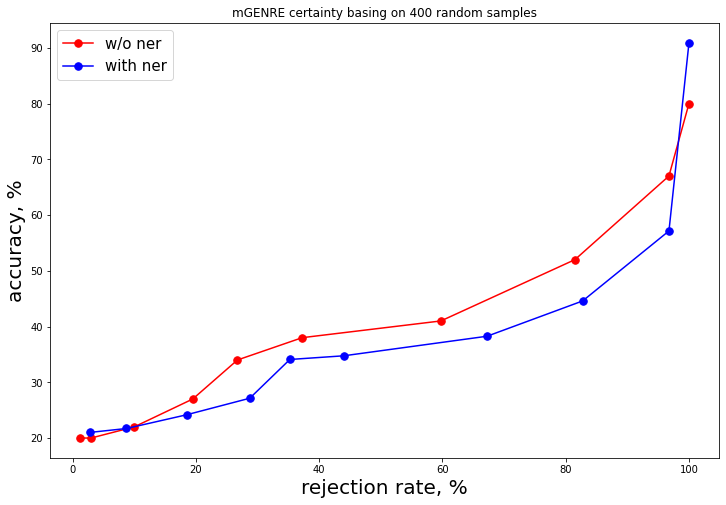

In [85]:
plt.figure(figsize = (12,8))
plt.xlabel("rejection rate, %", fontsize = 20)
plt.ylabel("accuracy, %", fontsize = 20)
plt.title("mGENRE certainty basing on 400 random samples")
plt.plot(share_of_observations_400_top_1[::-1], accuracy_400_top_1, label = "w/o ner", c = "red", marker = '.', markersize = 15);

plt.plot(share_of_observations_400_ner_top_1[::-1], accuracy_400_ner_top_1, label = "with ner", c = "blue", marker = '.', markersize = 15);
plt.legend(fontsize = 15);


# Another NER models

In [113]:
english_text = ''' I want a person available 7 days and with prompt response all most every time. Only Indian freelancer need I need PHP developer who have strong experience in Laravel and Codeigniter framework for daily 4 hours. I need this work by Monday 27th Jan. should be free from plagiarism . 
Need SAP FICO consultant for support project needs to be work on 6 months on FI AREAWe.  Want a same site to be created as the same as this https://www.facebook.com/?ref=logo, please check the site before contacting to me and i want this site to be ready in 10 days. They will be ready at noon tomorrow .'''

russian_text = '''Власти Москвы выделили 110 млрд рублей на поддержку населения, системы здравоохранения и городского хозяйства. Об этом сообщается на сайте мэра столицы https://www.sobyanin.ru/ в пятницу, 1 мая. По адресу Алтуфьевское шоссе д.51 (основной вид разрешенного использования: производственная деятельность, склады) размещен МПЗ? Подпоручик Киже управляя автомобилем ВАЗ2107 перевозил автомат АК47 с целью ограбления банка ВТБ24, как следует из записей. 
Взыскать c индивидуального предпринимателя Иванова Костантипа Петровича дата рождения 10 января 1970 года, проживающего по адресу город Санкт-Петербург, ул. Крузенштерна, дом 5/1А 8 000 (восемь тысяч) рублей 00 копеек гос. пошлины в пользу бюджета РФ Жители требуют незамедлительной остановки МПЗ и его вывода из района. Решение было принято по поручению мэра города Сергея Собянина в связи с ограничениями из-за коронавируса.'''


## 1) NLTK

In [114]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
for sent in nltk.sent_tokenize(english_text):
   for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
      if hasattr(chunk, 'label'):
         print(chunk)

[nltk_data] Downloading package punkt to /home/petrakov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/petrakov/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/petrakov/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /home/petrakov/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


(GPE Indian/JJ)
(ORGANIZATION PHP/NNP)
(GPE Laravel/NNP)
(PERSON Need/NNP)
(ORGANIZATION SAP/NNP)
(ORGANIZATION FI/NNP)


In [123]:
for i in range(1,100):
    for sent in nltk.sent_tokenize(data.loc[i,"question"]):
       for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
          if hasattr(chunk, 'label'):
             print(chunk)

(GPE Name/NN)
(PERSON Alan/NNP Pierson/NNP)
(GPE Which/NNP)
(GPE Name/NN)
(GPE Which/JJ)
(GPE Which/JJ)
(GPE Queens/NNP University/NNP)
(ORGANIZATION Bangladesh/NNP)
(PERSON Claire/NNP Stansfield/NNP)


## Spacy

In [132]:
import nltk.tag.stanford.StanfordNERTagger as StanfordNERTagger
jar = "stanford-ner-2015-04-20/stanford-ner-3.5.2.jar"
model = "stanford-ner-2015-04-20/classifiers/" 
st_3class = StanfordNERTagger(model + "english.all.3class.distsim.crf.ser.gz", jar, encoding='utf8') 
st_4class = StanfordNERTagger(model + "english.conll.4class.distsim.crf.ser.gz", jar, encoding='utf8') 
st_7class = StanfordNERTagger(model + "english.muc.7class.distsim.crf.ser.gz", jar, encoding='utf8')
for i in [st_3class.tag(english_text.split()), st_4class.tag(english_text.split()), st_7class.tag(english_text.split())]:
  for b in i:
    if b[1] != 'O':
        print(b)

ModuleNotFoundError: No module named 'nltk.tag.stanford.StanfordNERTagger'; 'nltk.tag.stanford' is not a package

In [134]:
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 14.0 MB/s eta 0:00:0000:0100:01
  Using cached catalogue-2.0.7-py3-none-any.whl (17 kB)
  Using cached pathy-0.6.2-py3-none-any.whl (42 kB)
  Using cached wasabi-0.9.1-py3-none-any.whl (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.9/835.9 kB 10.8 MB/s eta 0:00:0000:01
  Using cached pydantic-1.9.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
  Using cached spacy_loggers-1.0.2-py3-none-any.whl (7.2 kB)
  Using cached srsly-2.4.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (459 kB)
  Using cached spacy_legacy-3.0.9-py2.py3-none-any.whl (20 kB)
  Using cached typer-0.4.2-py3-none-any.whl (27 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached preshed-3.0.6-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (130 kB)
  Using cached cymem-2.0.6-cp

In [139]:
import spacy
import en_core_web_lg


model_sp = en_core_web_lg.load()
for ent in model_sp(english_text).ents:
  print(ent.text.strip(), ent.label_)

7 days DATE
Indian NORP
Laravel GPE
daily DATE
4 hours TIME
Monday 27th Jan. DATE
6 months DATE
https://www.facebook.com/?ref=logo ORG
10 days DATE
noon TIME
tomorrow DATE


In [147]:
for j, question in enumerate(list(data.loc[:100, 'question'])):
    print("question num: ", j, "\n", "question: ", question)
    for ent in model_sp(question).ents:
        print("entity: ", ent.text.strip(), "\n", "label: ", ent.label_, "\n")

question num:  0 
 question:  who is a musician born in detroit
entity:  detroit 
 label:  GPE 

question num:  1 
 question:  what is the language in which mera shikar was filmed in
entity:  mera shikar 
 label:  PERSON 

question num:  2 
 question:  Whats the name of a battle that happened in chicago
entity:  chicago 
 label:  GPE 

question num:  3 
 question:  what player plays the position midfielder?
question num:  4 
 question:  what is the position that  mike twellman plays
entity:  mike twellman 
 label:  PERSON 

question num:  5 
 question:  list some musical films
question num:  6 
 question:  what is ellen swallow richards's nationality?
entity:  richards 
 label:  PERSON 

question num:  7 
 question:  What language is the show elementary broadcast in?
question num:  8 
 question:  what is the gender of james hendry?
entity:  james hendry 
 label:  PERSON 

question num:  9 
 question:  who was a voice actor?
question num:  10 
 question:  What is a member of the 1893 ja

## Flair

In [148]:
from flair.models import SequenceTagger
tagger = SequenceTagger.load('ner')
from flair.data import Sentence
s = Sentence(english_text)
tagger.predict(s)
for entity in s.get_spans('ner'):
    print(entity)

2022-07-13 05:09:48,693 https://nlp.informatik.hu-berlin.de/resources/models/ner/en-ner-conll03-v0.4.pt not found in cache, downloading to /tmp/tmpqsq3oe4z


100%|██████████| 432197603/432197603 [00:38<00:00, 11342440.43B/s]

2022-07-13 05:10:26,989 copying /tmp/tmpqsq3oe4z to cache at /home/petrakov/.flair/models/en-ner-conll03-v0.4.pt


2022-07-13 05:10:27,364 removing temp file /tmp/tmpqsq3oe4z
2022-07-13 05:10:27,422 loading file /home/petrakov/.flair/models/en-ner-conll03-v0.4.pt


RuntimeError: CUDA error: no kernel image is available for execution on the device

## Deeppavlov

In [155]:
!pip install deeppavlov

Defaulting to user installation because normal site-packages is not writeable
  Using cached pydantic-1.3-cp38-cp38-manylinux2010_x86_64.whl (9.4 MB)
  Using cached numpy-1.18.0-cp38-cp38-manylinux1_x86_64.whl (20.6 MB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.9.1
    Uninstalling pydantic-1.9.1:
      Successfully uninstalled pydantic-1.9.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
      Successfully uninstalled numpy-1.23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.6.0 which is incompatible.
thinc 8.1.0 requires pydantic!=1.8,!=1.8.1,<1.10.0,>=1.7.4, but you have pydantic 1.3 which is incompatible.
spacy 3.4.0 requires pydantic!=1.8,!=1.8.1,<1.10.0,>=1.7.4, but you have pydantic 1.3 which is i

In [154]:
!python -m deeppavlov install ner_conll2003_bert

/usr/bin/python: No module named deeppavlov


In [149]:
from deeppavlov import configs, build_model
from deeppavlov import build_model, configs

ner_model = build_model(configs.ner.ner_ontonotes_bert, download=True)
result = ner_model([english_text])
for i in range(len(result[0][0])):
     if result [1][0][i] != 'O':
         print(result[0][0][i], result[1][0][i])

2022-07-13 05:11:52.89 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/deeppavlov_data/bert/cased_L-12_H-768_A-12.zip to /home/petrakov/.deeppavlov/downloads/cased_L-12_H-768_A-12.zip
100%|██████████| 404M/404M [00:09<00:00, 40.6MB/s] 
2022-07-13 05:12:02.504 INFO in 'deeppavlov.core.data.utils'['utils'] at line 272: Extracting /home/petrakov/.deeppavlov/downloads/cased_L-12_H-768_A-12.zip archive into /home/petrakov/.deeppavlov/downloads/bert_models
2022-07-13 05:12:06.584 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/deeppavlov_data/ner_ontonotes_bert_v1.tar.gz to /home/petrakov/.deeppavlov/ner_ontonotes_bert_v1.tar.gz
100%|██████████| 805M/805M [00:16<00:00, 49.6MB/s] 
2022-07-13 05:12:23.212 INFO in 'deeppavlov.core.data.utils'['utils'] at line 272: Extracting /home/petrakov/.deeppavlov/ner_ontonotes_bert_v1.tar.gz archive into /home/petrakov/.deeppavlov/models


ModuleNotFoundError: No module named 'bert_dp'

## adaptnlp

In [157]:
!pip install adaptnlp

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 3.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 5.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.9/248.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.9/881.9 MB 3.5 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 15.6 M

In [159]:
from adaptnlp import EasyTokenTagger
tagger = EasyTokenTagger()
sentences = tagger.tag_text(
    text = english_text, model_name_or_path = "ner-ontonotes"
)
spans = sentences[0].get_spans("ner")
for sen in sentences:
    for entity in sen.get_spans("ner"):
        print(entity)

TypeError: __init__() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

In [161]:
!pip install stanza

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 574.7/574.7 kB 2.8 MB/s eta 0:00:0000:0100:01


In [162]:
import stanza
stanza.download('en')
def stanza_nlp(text):
  nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')
  doc = nlp(text)
  print(*[f'entity: {ent.text}\ttype: {ent.type}' for sent in doc.sentences for ent in sent.ents], sep='\n')
stanza_nlp(english_text)

2022-07-13 05:19:01 INFO: Downloading default packages for language: en (English)...


2022-07-13 05:19:13 INFO: Finished downloading models and saved to /home/petrakov/stanza_resources.


2022-07-13 05:19:14 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2022-07-13 05:19:14 INFO: Use device: gpu
2022-07-13 05:19:14 INFO: Loading: tokenize


RuntimeError: CUDA error: no kernel image is available for execution on the device

In [164]:
!pip install allennlp

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.6/719.6 kB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.9/305.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 4.4 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 27.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.1/592.1 kB 15.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 23.0 MB/s eta 0:00:0000:0100:01
     ━━━━

In [165]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.ner.crf_tagger
predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/ner-model-2020.02.10.tar.gz")
allen_result = predictor.predict(
  sentence=english_text
)
for i in zip(allen_result['tags'], allen_result['words']):
    if (i[0]) != 'O':
      print(i)

ImportError: cannot import name 'AcquireReturnProxy' from 'filelock' (/home/petrakov/.local/lib/python3.8/site-packages/filelock.py)

In [47]:
sentences = NER(text = '¿Quien descubrio America?',
                tokenizer_name = "Babelscape/wikineural-multilingual-ner",
                model_name = "Babelscape/wikineural-multilingual-ner")

sentences

'¿Quien descubrio [START] America [END] ?'

In [48]:
#sentences = ["[START] The founder of the theory of relativity [END] received the Nobel Prize."]
model_mGENRE.sample(
    sentences = [sentences],
    beam = 5,
    prefix_allowed_tokens_fn=lambda batch_id, sent: [
        e for e in trie.get(sent.tolist())
        if e < len(model_mGENRE.task.target_dictionary)
    ],
    text_to_id=lambda x: max(lang_title2wikidataID[tuple(reversed(x.split(" >> ")))], key=lambda y: int(y[1:])),
    marginalize=True,
    verbose = True
)

[[{'id': 'Q828',
   'texts': ['América >> es', 'America >> es'],
   'scores': tensor([-0.1263, -1.3828]),
   'score': tensor(-0.1747)},
  {'id': 'Q29409515',
   'texts': ['América (desambiguación) >> es',
    'América (desambiguação) >> pt'],
   'scores': tensor([-0.3790, -1.0400]),
   'score': tensor(-1.0819)},
  {'id': 'Q18',
   'texts': ['América del Sur >> es'],
   'scores': tensor([-1.0630]),
   'score': tensor(-2.6038)}]]

# New experiment GENRE

## !!! you have to uncomment cells below to load data if it is 1 time

In [23]:
# ## Data and dependencies

# id_p_e_m = "1C2R814tsgZbREaaOk6o9nh3lQn308Wo7"
# gdown.download(id=id_p_e_m, output="prob_yago_crosswikis_wikipedia_p_e_m.txt", quiet=False)

# %mkdir data
# %cd data
# %mkdir dalab
# %cd ..

# %mv prob_yago_crosswikis_wikipedia_p_e_m.txt data/dalab/prob_yago_crosswikis_wikipedia_p_e_m.txt

# ! wget http://resources.mpi-inf.mpg.de/yago-naga/aida/download/aida_means.tsv.bz2
# ! bzip2 -dk aida_means.tsv.bz2

# %cd data 
# %mkdir aida
# %cd ..

# %mv aida_means.tsv data/aida/aida_means.tsv

In [24]:
# def read_dalab_candidates():
#     for line in open("data/dalab/prob_yago_crosswikis_wikipedia_p_e_m.txt"):
#         line = line[:-1]
#         columns = line.split("\t")
#         mention = columns[0]
#         for column in columns[2:]:
#             if len(column.strip()) == 0:
#                 continue
#             values = column.split(",")
#             candidate = ",".join(values[2:])
#             candidate = candidate.replace("_", " ")
#             yield mention, candidate


# def hex2int(hexa: str) -> int:
#     return int(hexa, 16)


# def replace_unicode(u_str):
#     matches = set(re.findall("\\\\u....", u_str))
#     for match in matches:
#         u_str = u_str.replace(match, chr(hex2int(match[2:])))
#     return u_str


# PUNCTUATION_CHARS = set(string.punctuation)


# def filter_mention(mention):
#     if mention[0].islower():
#         return True
#     if mention[0] in PUNCTUATION_CHARS:
#         return True
#     return False


# def read_aida_candidates():
#     for line in open("data/aida/aida_means.tsv"):
#         line = line[:-1]
#         values = line.split("\t")
#         mention = replace_unicode(values[0][1:-1])
#         candidate = replace_unicode(values[1]).replace("_", " ")
#         yield mention, candidate


# #making mention_candidates_dict
# #once done no need to do again

# mention_candidates_dict = {}
# for mention, candidate in itertools.chain(read_dalab_candidates(), read_aida_candidates()):
#     if filter_mention(mention):
#         continue
#     if mention not in mention_candidates_dict:
#         mention_candidates_dict[mention] = set()
#     mention_candidates_dict[mention].add(candidate)
# for mention in mention_candidates_dict:
#     mention_candidates_dict[mention] = sorted(mention_candidates_dict[mention])
# with open("data/mention_candidates_dict.pkl", "wb") as f:
#     pickle.dump(mention_candidates_dict, f)

In [25]:
# %mkdir models

In [26]:
# # making mention_trie
# # once done no need to do again

# sys.setrecursionlimit(10000)
# model_path = "fairseq_e2e_entity_linking_wiki_abs"
# model = GENRE.from_pretrained(model_path).eval()
# with open("data/mention_candidates_dict.pkl", "rb") as f:
#     mention_to_candidates_dict = pickle.load(f)
# mention_trie = Trie()
# for mention in tqdm(mention_to_candidates_dict):
#     encoded = model.encode(" {}".format(mention))[1:].tolist()
#     mention_trie.add(encoded)
# out_file = "data/mention_trie.pkl"
# with open(out_file, "wb") as f:
#     pickle.dump(mention_trie, f)

### example from git

In [27]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Markdown
import pickle
import sys

from GENRE.genre.utils import get_entity_spans_fairseq as get_entity_spans
from GENRE.genre.utils import get_markdown


from GENRE.genre.trie import Trie, MarisaTrie
from GENRE.genre.fairseq_model import mGENRE
from GENRE.genre.fairseq_model import GENRE


model_path_genre = "fairseq_e2e_entity_linking_wiki_abs"
model_path_mgenre = "fairseq_multilingual_entity_disambiguation"
dict_path = "data/mention_candidates_dict.pkl"
trie_path = "data/mention_trie.pkl"

model = GENRE.from_pretrained(model_path_genre).eval()

with open(trie_path, "rb") as f:
    mention_trie = pickle.load(f)
with open(dict_path, "rb") as f:
    mention_to_candidates_dict = pickle.load(f)

text = """Home Depot CEO Nardelli quits Home-improvement retailer's chief executive had been criticized over pay ATLANTA - Bob Nardelli abruptly resigned Wednesday as chairman and chief executive of The Home Depot Inc. after a six-year tenure that saw the world’s largest home improvement store chain post big profits but left investors disheartened by poor stock performance. Nardelli has also been under fire by investors for his hefty pay and is leaving with a severance package valued at about $210 million. He became CEO in December 2000 after being passed over for the top job at General Electric Co., where Nardelli had been a senior executive. Home Depot said Nardelli was being replaced by Frank Blake, its vice chairman, effective immediately. Blake’s appointment is permanent, Home Depot spokesman Jerry Shields said. What he will be paid was not immediately disclosed, Shields said. The company declined to make Blake available for comment, and a message left for Nardelli with his secretary was not immediately returned. Before Wednesday’s news, Home Depot’s stock had been down more than 3 percent on a split-adjusted basis since Nardelli took over. Nardelli’s sudden departure was stunning in that he told The Associated Press as recently as Sept. 1 that he had no intention of leaving, and a key director also said that the board was pleased with Nardelli despite the uproar by some investors. Asked in that interview if he had thought of hanging up his orange apron and leaving Home Depot, Nardelli said unequivocally that he hadn’t. Asked what he thought he would be doing 10 years from now, Nardelli said, “Selling hammers.” For The Home Depot? “Absolutely,” he said at the time. Home Depot said Nardelli’s decision to resign was by mutual agreement with the Atlanta-based company. “We are very grateful to Bob for his strong leadership of The Home Depot over the past six years. Under Bob’s tenure, the company made significant and necessary investments that greatly improved the company’s infrastructure and operations, expanded our markets to include wholesale distribution and new geographies, and undertook key strategic initiatives to strengthen the company’s foundation for the future,” Home Depot’s board said in a statement. Nardelli was a nuts-and-bolts leader, a former college football player and friend of President Bush. He helped increase revenue and profits at Home Depot and increase the number of stores the company operates to more than 2,000. Home Depot’s earnings per share have increased by approximately 150 percent over the last five years."""

sentences = [text]
entity_spans = get_entity_spans(
    model,
    sentences,
    mention_trie=mention_trie,
    mention_to_candidates_dict=mention_to_candidates_dict
)
markdown = get_markdown(sentences, entity_spans)[0]

In [28]:
Markdown(markdown)

[Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) CEO Nardelli quits Home-improvement retailer's chief executive had been criticized over pay ATLANTA - [Bob Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) abruptly resigned Wednesday as chairman and chief executive of [The Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) Inc. after a six-year tenure that saw the world’s largest home improvement store chain post big profits but left investors disheartened by poor stock performance. [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) has also been under fire by investors for his hefty pay and is leaving with a severance package valued at about $210 million. He became CEO in December 2000 after being passed over for the top job at [General Electric](https://en.wikipedia.org/wiki/General_Electric) Co., where [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) had been a senior executive. [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) said [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) was being replaced by [Frank Blake](https://en.wikipedia.org/wiki/Frank_Blake), its vice chairman, effective immediately. [Blake](https://en.wikipedia.org/wiki/Frank_Blake)’s appointment is permanent, [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) spokesman [Jerry Shields](https://en.wikipedia.org/wiki/Jerry_A._Shields) said. [What](https://en.wikipedia.org/wiki/What?_(film)) he will be paid was not immediately disclosed, [Shields](https://en.wikipedia.org/wiki/Jerry_A._Shields) said. [The](https://en.wikipedia.org/wiki/The_Home_Depot) company declined to make [Blake](https://en.wikipedia.org/wiki/Frank_Blake) available for comment, and a message left for [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) with his secretary was not immediately returned. [Before](https://en.wikipedia.org/wiki/Before_(song)) Wednesday’s news, [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot)’s stock had been down more than 3 percent on a split-adjusted basis since [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) took over. [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli)’s sudden departure was stunning in that he told [The](https://en.wikipedia.org/wiki/The_Home_Depot) Associated Press as recently as Sept. 1 that he had no intention of leaving, and a key director also said that the board was pleased with [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) despite the uproar by some investors. Asked in that interview if he had thought of hanging up his orange apron and leaving [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot), [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) said unequivocally that he hadn’t. Asked what he thought he would be doing [10](https://en.wikipedia.org/wiki/10_(film)) years from now, [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli) said, “Selling hammers.” For [The](https://en.wikipedia.org/wiki/The_Mr._T_Experience) Home Depot? “Absolutely,” he said at the time. [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) said [Nardelli](https://en.wikipedia.org/wiki/Robert_Nardelli)’s decision to resign was by mutual agreement with the [Atlanta](https://en.wikipedia.org/wiki/Decatur,_Georgia)-based company. “We are very grateful to [Bob](https://en.wikipedia.org/wiki/Barbecue_Bob) for his strong leadership of [The](https://en.wikipedia.org/wiki/U.S._Department_of_State_Foreign_Affairs_Manual) [Home Depot](https://en.wikipedia.org/wiki/The_Home_Depot) over the past six years. Under [Bob](https://en.wikipedia.org/wiki/Bank_of_Baroda)’s tenure, the company made significant and necessary investments that greatly improved the company’s infrastructure and operations, expanded our markets to include wholesale distribution and new geographies, and undertook key strategic initiatives to strengthen the company’s foundation for the future,” [Home](https://en.wikipedia.org/wiki/John_Home) [Depot](https://en.wikipedia.org/wiki/Depot)’s board said in a statement. [Nardelli](https://en.wikipedia.org/wiki/Nardelli) was a nuts-and-bolts leader, a former college football player and friend of [President](https://en.wikipedia.org/wiki/Senegalese_presidential_election,_2007) Bush. [He](https://en.wikipedia.org/wiki/J._M._E._McTaggart) helped increase revenue and profits at [Home](https://en.wikipedia.org/wiki/New_Recreation_Ground) [Depot](https://en.wikipedia.org/wiki/Depot) and increase the number of stores the company operates to more than [2](https://en.wikipedia.org/wiki/U.S._Route_2),000. [Home](https://en.wikipedia.org/wiki/New_Recreation_Ground) [Depot](https://en.wikipedia.org/wiki/Depot)’s earnings per share have increased by approximately [150](https://en.wikipedia.org/wiki/U.S._Route_150) percent over the last five years.

### mGENRE case

In [40]:
from GENRE.genre.utils import get_entity_spans_fairseq

In [49]:
model = mGENRE.from_pretrained(model_path_mgenre).eval()

In [52]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model.to(device)

GENREHubInterface(
  (models): ModuleList(
    (0): BARTModel(
      (encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(256001, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDro

In [47]:
sentences = ["Moscow is the capital of Russia, where such great people as Kondratiev and Kolmogorov lived in 20 century"]
entity_spans = get_entity_spans_fairseq(
    model,
    sentences,
#    mention_trie=mention_trie,
#    mention_to_candidates_dict=mention_to_candidates_dict
)


TypeError: expected string or bytes-like object

In [53]:
model.

GENREHubInterface(
  (models): ModuleList(
    (0): BARTModel(
      (encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(256001, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDro

In [37]:
markdown = get_markdown(sentences, entity_spans)[0]

In [38]:
Markdown(markdown)

[Moscow](https://en.wikipedia.org/wiki/Moscow) is the capital of [Russia](https://en.wikipedia.org/wiki/Russia), where such great people as [Kondratiev](https://en.wikipedia.org/wiki/Mikhail_Kondratiev) and [Kolmogorov](https://en.wikipedia.org/wiki/Andrey_Kolmogorov) lived in 20 century

# Estimate scores

In [29]:
from GENRE.genre.utils import get_entity_spans_fairseq as get_entity_spans

In [30]:
documents = {
    "id_0": "In 1921, Einstein received a Nobel Prize.",
    "id_1": "Armstrong was the first man on the Moon.",
}

gold_entities = [
    ("id_0", 3, 4, "1921"),
    ("id_0", 9, 8, 'Albert_Einstein'),
    ("id_0", 29, 11, 'Nobel_Prize_in_Physics'),
    ("id_1", 0, 9, 'Neil_Armstrong'),
    ("id_1", 35, 4, 'Moon'),
]

In [31]:
guess_entities = get_entity_spans(
    model,
    list(documents.values()),
)
print("guess_entities", guess_entities)
print("#############")

guess_entities = [
    (k,) + x
    for k, e in zip(documents.keys(), guess_entities)
    for x in e
]
print("guess_entities", guess_entities)

guess_entities [[(0, 7, 'List_of_Nobel_laureates_by_year_of_appointment'), (9, 8, 'Albert_Einstein'), (29, 11, 'Nobel_Prize_in_Physiology_or_Medicine'), (40, 1, 'List_of_Nobel_laureates_in_Physiology_or_Medicine_by_year_of_appointment')], [(18, 9, 'First_Man_(film)'), (35, 4, 'Moon_(TV_series)_(1968_TV_series,_season_1)'), (39, 1, 'Moon_(TV_series,_season_1)')]]
#############
guess_entities [('id_0', 0, 7, 'List_of_Nobel_laureates_by_year_of_appointment'), ('id_0', 9, 8, 'Albert_Einstein'), ('id_0', 29, 11, 'Nobel_Prize_in_Physiology_or_Medicine'), ('id_0', 40, 1, 'List_of_Nobel_laureates_in_Physiology_or_Medicine_by_year_of_appointment'), ('id_1', 18, 9, 'First_Man_(film)'), ('id_1', 35, 4, 'Moon_(TV_series)_(1968_TV_series,_season_1)'), ('id_1', 39, 1, 'Moon_(TV_series,_season_1)')]


In [32]:
from GENRE.genre.utils import (
    get_micro_precision,
    get_micro_recall,
    get_micro_f1,
    get_macro_precision,
    get_macro_recall,
    get_macro_f1,
)

micro_p = get_micro_precision(guess_entities, gold_entities)
micro_r = get_micro_recall(guess_entities, gold_entities)
micro_f1 = get_micro_f1(guess_entities, gold_entities)
macro_p = get_macro_precision(guess_entities, gold_entities)
macro_r = get_macro_recall(guess_entities, gold_entities)
macro_f1 = get_macro_f1(guess_entities, gold_entities)

print(
   "micro_p={:.4f} micro_r={:.4f}, micro_f1={:.4f}, macro_p={:.4f}, macro_r={:.4f}, macro_f1={:.4f}".format(
       micro_p, micro_r, micro_f1, macro_p, macro_r, macro_f1
   )
)

micro_p=0.1429 micro_r=0.2000, micro_f1=0.1667, macro_p=0.1250, macro_r=0.1667, macro_f1=0.1429


# load mewsli-9

In [39]:
import pandas as pd
import bz2

In [40]:
#en_df = pd.read_csv('dataset/en/mentions.tsv', sep='\t')
#en_df_doc = pd.read_csv('docs.tsv', sep='\t')
en_df_doc = pd.read_csv('mewsli_9/dense_representations_for_entity_retrieval/mel/mewsli-9/output/dataset/en/docs.tsv', sep='\t')
en_df_men = pd.read_csv('mewsli_9/dense_representations_for_entity_retrieval/mel/mewsli-9/output/dataset/en/mentions.tsv', sep='\t')



In [37]:
%cd mewsli_9/dense_representations_for_entity_retrieval/mel

/home/petrakov/success/mGENRE_MEL/mewsli_9/dense_representations_for_entity_retrieval/mel


In [28]:
with bz2.open("mewsli-9/output/wikiextractor/en/AA/wiki_00.bz2", "rb") as f:
    # Decompress data from file
    en_wiki = f.read()



In [38]:
%cd mewsli-9/output/output/dataset/en/text

/home/petrakov/success/mGENRE_MEL/mewsli_9/dense_representations_for_entity_retrieval/mel/mewsli-9/output/output/dataset/en/text


In [41]:
a = en_df_men[en_df_men['docid'] == "en-106602"]
b = en_df_men[en_df_men["docid"] == "en-106608"].reset_index()
c = en_df_men[en_df_men["docid"] == "en-106610"].reset_index()

In [42]:
%cd /home/petrakov/success/mGENRE_MEL

/home/petrakov/success/mGENRE_MEL


In [54]:
directory = "mewsli_9/dense_representations_for_entity_retrieval/mel/mewsli-9/output/output/dataset/en/text/"
texts = []
for st in ["en-106602", "en-106608", "en-106610"]:
    with open(directory + st, "r") as f:
        string = f.read()
    
    string = string.replace("\n", " ").replace("\xa0", "")
    string = string.replace("_", " ")
    string = string.replace("\n", " ")
    texts.append(string)


In [44]:
# documents = {
#     "id_0": texts[0],
#     "id_1": texts[1],
#     "id_2": texts[2],
# }

documents = {
    "id_0": "In 1921, Einstein received a Nobel Prize.",
    "id_1": "Armstrong was the first man on the Moon.",
}



gold_entities = [
    ("id_0", 3, 4, "1921"),
    ("id_0", 9, 8, 'Albert_Einstein'),
    ("id_0", 29, 11, 'Nobel_Prize_in_Physics'),
    ("id_1", 0, 9, 'Neil_Armstrong'),
    ("id_1", 35, 4, 'Moon'),
]

In [55]:
documents = {
    "id_0": texts[0],
    "id_1": texts[1],
    "id_2": texts[2],
}

gold_entities = [*[tuple(["id_0", *list(a.loc[i, ["position", "length", "mention"]])]) for i in range(len(a))],
                *[tuple(["id_1", *list(b.loc[i, ["position", "length", "mention"]])]) for i in range(len(b))],
                *[tuple(["id_2", *list(c.loc[i, ["position", "length", "mention"]])]) for i in range(len(c))]]


In [56]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Markdown
import pickle
import sys

from GENRE.genre.utils import get_entity_spans_fairseq as get_entity_spans
from GENRE.genre.utils import get_markdown


from GENRE.genre.trie import Trie, MarisaTrie
from GENRE.genre.fairseq_model import mGENRE
from GENRE.genre.fairseq_model import GENRE


model_path_genre = "fairseq_e2e_entity_linking_wiki_abs"
model_path_mgenre = "fairseq_multilingual_entity_disambiguation"
dict_path = "data/mention_candidates_dict.pkl"
trie_path = "data/mention_trie.pkl"

model = GENRE.from_pretrained(model_path_genre).eval()

In [57]:
guess_entities = get_entity_spans(
    model,
    list(documents.values()),
)

In [58]:
guess_entities_1 = [
    (k,*x)
    for k, e in zip(documents.keys(), guess_entities)
    for x in e
]

In [59]:
from GENRE.genre.utils import (
    get_micro_precision,
    get_micro_recall,
    get_micro_f1,
    get_macro_precision,
    get_macro_recall,
    get_macro_f1,
)

micro_p = get_micro_precision(guess_entities_1, gold_entities)
micro_r = get_micro_recall(guess_entities_1, gold_entities)
micro_f1 = get_micro_f1(guess_entities_1, gold_entities)
macro_p = get_macro_precision(guess_entities_1, gold_entities)
macro_r = get_macro_recall(guess_entities_1, gold_entities)
macro_f1 = get_macro_f1(guess_entities_1, gold_entities)

print(
   "micro_p={:.4f} micro_r={:.4f}, micro_f1={:.4f}, macro_p={:.4f}, macro_r={:.4f}, macro_f1={:.4f}".format(
       micro_p, micro_r, micro_f1, macro_p, macro_r, macro_f1
   )
)

micro_p=0.0000 micro_r=0.0000, micro_f1=0.0000, macro_p=0.0000, macro_r=0.0000, macro_f1=0.0000


In [60]:
from GENRE.genre.utils import (
    get_micro_precision,
    get_micro_recall,
    get_micro_f1,
    get_macro_precision,
    get_macro_recall,
    get_macro_f1,
)

micro_p = get_micro_precision(guess_entities_1, gold_entities)
micro_r = get_micro_recall(guess_entities_1, gold_entities)
micro_f1 = get_micro_f1(guess_entities_1, gold_entities)
macro_p = get_macro_precision(guess_entities_1, gold_entities)
macro_r = get_macro_recall(guess_entities_1, gold_entities)
macro_f1 = get_macro_f1(guess_entities_1, gold_entities)

print(
   "micro_p={:.4f} micro_r={:.4f}, micro_f1={:.4f}, macro_p={:.4f}, macro_r={:.4f}, macro_f1={:.4f}".format(
       micro_p, micro_r, micro_f1, macro_p, macro_r, macro_f1
   )
)

micro_p=0.0000 micro_r=0.0000, micro_f1=0.0000, macro_p=0.0000, macro_r=0.0000, macro_f1=0.0000


In [61]:
gold_entities

[('id_0', 145, 39, 'Pacific Marine Environmental Laboratory'),
 ('id_0', 365, 15, 'Baja California'),
 ('id_0', 1013, 13, 'oceanographer'),
 ('id_0', 1109, 5, 'Earth'),
 ('id_0', 1150, 14, 'carbon dioxide'),
 ('id_0', 1278, 9, 'carbonate'),
 ('id_0', 1385, 13, 'carbonic acid'),
 ('id_0', 1769, 21, 'Industrial Revolution'),
 ('id_1', 118, 33, '2006 Lathen maglev train accident'),
 ('id_1', 231, 6, 'maglev'),
 ('id_1', 358, 11, 'human error'),
 ('id_1', 454, 10, 'Transrapid'),
 ('id_1', 471, 2, 'cm'),
 ('id_1', 583, 9, 'Osnabrück'),
 ('id_1', 643, 4, 'euro'),
 ('id_2', 189, 8, 'asbestos'),
 ('id_2', 423, 16, 'terminal illness'),
 ('id_2', 459, 12, 'mesothelioma'),
 ('id_2', 520, 12, 'James Hardie'),
 ('id_2', 634, 10, 'asbestosis'),
 ('id_2', 693, 13, 'lung scarring'),
 ('id_2', 812, 6, 'cancer'),
 ('id_2', 861, 22, 'lungs and chest cavity'),
 ('id_2', 885, 16, 'abdominal cavity'),
 ('id_2', 910, 25, 'sac surrounding the heart'),
 ('id_2', 1136, 17, 'Victorian Premier'),
 ('id_2', 1154, 

In [68]:
texts[0][365-1:365+15-1]

'Baja California'

In [62]:
guess_entities_1

[('id_0', 0, 4, 'National_Oceanic_and_Atmospheric_Administration'),
 ('id_0', 87, 49, 'National_Oceanic_and_Atmospheric_Administration'),
 ('id_0',
  144,
  39,
  'National_Oceanic_and_Atmospheric_Administration_National_Marine_Environmental_Laboratory'),
 ('id_0', 210, 14, 'World_Ocean'),
 ('id_0', 345, 13, 'Pacific_Ocean'),
 ('id_0', 364, 23, 'Baja_California'),
 ('id_0', 391, 27, 'Vancouver'),
 ('id_0', 491, 17, 'Continental_shelf'),
 ('id_0', 556, 13, 'Marine_life'),
 ('id_0',
  586,
  6,
  'Oceanic_carbonate_marine_life_in_the_United_States_and_Great_Britain_of_Great_Britain_and_Ireland_of_1844–1855'),
 ('id_0', 675, 10, 'California'),
 ('id_0',
  703,
  13,
  'List_of_countries_by_number_of_military_and_paramilitary_personnel_in_the_second_year_of_conflict_with_the_United_States_(1944–46)'),
 ('id_0', 719, 72, 'Ocean_acidification'),
 ('id_0', 819, 11, 'Marine_life'),
 ('id_0',
  838,
  17,
  'Continental_shelf_of_the_United_States_and_Great_Britain_of_Great_Britain_of_1844–1855_

In [56]:
%ls

aida_means.tsv.bz2
data/
dataset/
docs.tsv
fairseq/
fairseq_e2e_entity_linking_wiki_abs/
fairseq_multilingual_entity_disambiguation/
fairseq_multilingual_entity_disambiguation.tar.gz
GENRE/
KILT/
lang_title2wikidataID-normalized_with_redirect.pkl
mentions_test.json
mentions.tsv
mewsli_9/
mgenre_final.ipynb.invalid
mgenre_final_with_mewsli.ipynb
README.md
requirements.txt
titles_lang_all105_marisa_trie_with_redirect.pkl


In [59]:
!pip install hanziconv

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.8/276.8 kB 2.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for hanziconv: filename=hanziconv-0.3.2-py2.py3-none-any.whl size=23225 sha256=800fc8bc3ee5cfe9cacd7ccd8335d3cab8f5284f0eece677b82e7ac0eec312f5
  Stored in directory: /home/petrakov/.cache/pip/wheels/24/bc/5f/95aceeea892d9bf06c29a9effde5908abcefd3fa23244fdaa5
Successfully built hanziconv


In [84]:
from GENRE.scripts_mgenre.evaluate_kilt_dataset import evaluate_kilt_dataset

In [70]:
#!wget http://dl.fbaipublicfiles.com/GENRE/ace2004-test-kilt.jsonl
#!wget http://dl.fbaipublicfiles.com/KILT/fever-dev-kilt.jsonl
#!wget http://dl.fbaipublicfiles.com/GENRE/fairseq_wikipage_retrieval.tar.gz
!wget http://dl.fbaipublicfiles.com/KILT/wned-dev-kilt.jsonl

--2022-07-06 02:07:20--  http://dl.fbaipublicfiles.com/KILT/wned-dev-kilt.jsonl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12868348 (12M) [text/plain]
Saving to: ‘wned-dev-kilt.jsonl’

wned-dev-kilt.jsonl 100%[===================>]  12.27M  7.99MB/s    in 1.5s    

2022-07-06 02:07:22 (7.99 MB/s) - ‘wned-dev-kilt.jsonl’ saved [12868348/12868348]



In [85]:
import json

with open('wned-dev-kilt.jsonl', 'r') as f:
    wned = f.read()

In [86]:
evaluate_kilt_dataset(model = model_mGENRE, dataset = wned)

Evaluating :   0%|          | 0/12852476 [00:00<?, ?it/s]

TypeError: string indices must be integers

In [67]:
fever['meta']

TypeError: list indices must be integers or slices, not str

# Additional info

### Another example

In [24]:
client = Client()  # doctest: +SKIP
entity = client.get('Q20145', load=True)
entity, entity.description

(<wikidata.entity.Entity Q20145 'IU'>,
 m'Korea  singer,actress record producer (2017)')

In [25]:
class bcolors:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Below we present a function that illustrates predicted entity, text, right answer basing on the id as input

In [36]:
def predict_from_test_set(idx=0):
    print(test_set[str(idx)]['mention_its']+"\n")
    start = test_set[str(idx)]['start_index']
    end = test_set[str(idx)]['end_index']
    mention_id = test_set[str(idx)]['mention_id']
    text = test_set[str(idx)]['source_document']['text']
    text = text[:start]+"[START] "+text[start:end]+" [END]"+text[end:]
    print(f'{text[:start]}{bcolors.BOLD}{text[start:end+len("[START] ")+len(" [END]")]}{bcolors.END}{text[end+len("[START] ")+len(" [END]"):]}\n')
    result = model.sample(
    sentences=[text],
    text_to_id=lambda x: sorted(list(lang_title2wikidataID.get(
        tuple(reversed((x.split(" >> ")[0], x.split(" >> ")[1][:2]))), [None])))[0],
    marginalize=True)
    print(result)
    
    entity = client.get(mention_id, load=True)
    print(f'\nCorrect entity : {mention_id, entity.label, entity.description}\n')

    candidates = [(i['id'], client.get(i['id'], load=True)) for i in result[0]]
    print('Predicted entities:')
    for i, entity in candidates:
        if i is not None:
            print(f'{i, entity.label, entity.description}')

In [37]:
predict_from_test_set(2354)

New South Wales

Bathurst Regional Council, the local government responsible for the city of Bathurst and its surrounds in Central Western [START] New South Wales [END], Australia yesterday revealed it had received a development application for the new Bathurst Base Hospital.The new hospital is to be built behind the current hospital on the same site and is expected to cost the New South Wales government AUD96 million. The Bathurst Hospital will be the first in the Bathurst-Orange-Bloomfield redevelopment project.The new hospital will have 149 beds, up from 85 for the current hospital. The hospital will also feature a mental health unit - previously psychiatric patients had to travel to Orange to the Bloomfield Hospital for treatment.The Bathurst Hospital is expected to have state-of-the art facilities and will share some services with the to be constructed Orange Base Hospital.The Bathurst Regional Council has approved the demolition of 12 buildings on the hospital site for enabling w

# Preliminary results:

Language: **fa** (5 out of 61)

Micro average (k=1): **1.0**

Language: **sr** (105 out of 451)

Micro average (k=1): **0.90476**

Language: **ta** (25 out of 366)

Micro average (k=1): **1.0**

### Macro average (k=1): 0.96825

In [28]:
from tqdm import tqdm
from multiprocessing import Pool

In [29]:
from fairseq.data.data_utils import collate_tokens


def compute_results(idx):
    start = test_set[str(idx)]['start_index']
    end = test_set[str(idx)]['end_index']
    mention_id = test_set[str(idx)]['mention_id']
    text = test_set[str(idx)]['source_document']['text']
    text = text[:start]+"[START] "+text[start:end]+" [END]"+text[end:]
    print(start, end, min(start, len(text)-end))
    #encoder = model.encoder(text)
    #print(encoder)

    result = model.sample(
                    sentences=[text],
                   text_to_id=lambda x: sorted(list(lang_title2wikidataID.get(
       tuple(reversed((x.split(" >> ")[0], x.split(" >> ")[1][:2]))), [None])))[0],
                    marginalize=True)
    candidates = [(i['id'], client.get(i['id'], load=True)) for i in result[0] if i['id'] is not None]
    entity = client.get(mention_id, load=True)
    return {
            "correct": mention_id, 
            "predicted": [i for i, _ in candidates]
               }

In [30]:
compute_results(1)

100 109 100


{'correct': 'Q36678', 'predicted': ['Q36678', 'Q2564150', 'Q7834492']}

In [32]:
def compute_scores(lang='en', k_list=[1, 10, 20, 50, 100]):
    scores = []
    
    for idx in tqdm(langs_idx[lang]):
        scores.append(compute_results(idx))
    return scores

In [33]:
langs_idx = {
    'ar':[], 'en':[], 'tr':[]
}
for idx in test_set:
    el = test_set[idx]
    lang = el['document_id'][:2]
    if lang in langs_idx:
        langs_idx[lang].append(int(idx))

In [ ]:
def micro_avg_lang(scores, lang='en', k_list=[1, 10, 20, 50, 100]):    
    print(f'Language: {lang}')
    results = []
    for k in k_list:
        n = 0
        for i, row in enumerate(scores):
            if scores['correct'] in scores['predicted'][:k]:
                n += 1
        results.append(round(n / total_mentions, 5))
    for i, k in enumerate(k_list):
        print(f'Micro average (k={k}):', results[i])
    return results